# Wellbeing Clustering Analysis

## Section 1: Determine Optimal Number of Clusters

This notebook performs clustering analysis on the wellbeing and lifestyle dataset.

### Objectives:
- Load processed data from Step 2
- Apply Elbow Method (WCSS)
- Calculate Silhouette Scores for k=2 to k=8
- Calculate Davies-Bouldin Index
- Visualize results to justify optimal cluster selection (targeting 4-5 clusters)

---


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

COLORS = {'primary': '#0D7377', 'secondary': '#14BDEB', 'accent': '#FF6B6B', 
          'accent2': '#FFE66D', 'dark': '#1A1A2E'}

plt.rcParams['figure.facecolor'] = '#FAFBFC'
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")


Libraries imported successfully!


## 1.1 Load Data


In [2]:
# Load processed data
processed_path = 'data/processed_wellbeing_data.csv'
raw_path = 'Wellbeing_and_lifestyle_data_Kaggle.csv'

if os.path.exists(processed_path):
    df = pd.read_csv(processed_path)
    print(f"Loaded from: {processed_path}")
else:
    print("Processing raw data...")
    df_raw = pd.read_csv(raw_path)
    
    # Handle AGE column - map categorical age ranges to numeric values
    if 'AGE' in df_raw.columns:
        age_mapping = {
            'Less than 20': 18,
            '21 to 35': 28,
            '36 to 50': 43,
            '51 or more': 60
        }
        df_raw['AGE'] = df_raw['AGE'].map(age_mapping)
    
    numeric_cols = [c for c in df_raw.columns if c not in ['Timestamp', 'GENDER']]
    for col in numeric_cols:
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    
    scaler = MinMaxScaler()
    df_raw[numeric_cols] = scaler.fit_transform(df_raw[numeric_cols].fillna(0))
    os.makedirs('data', exist_ok=True)
    df_raw.to_csv(processed_path, index=False)
    df = df_raw
    print("Data processed and saved!")

print(f"Shape: {df.shape}")


Loaded from: data/processed_wellbeing_data.csv
Shape: (15972, 35)


In [3]:
# Select features for clustering
features = ['FRUITS_VEGGIES', 'DAILY_STRESS', 'SLEEP_HOURS', 'DAILY_STEPS',
            'FLOW', 'WEEKLY_MEDITATION', 'TODO_COMPLETED', 'ACHIEVEMENT',
            'TIME_FOR_PASSION', 'WORK_LIFE_BALANCE_SCORE']

X = df[[f for f in features if f in df.columns]].copy()

# Convert all columns to numeric (coerce errors to NaN)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.fillna(X.median())

# Check for and handle any remaining NaN values
if X.isna().sum().sum() > 0:
    print(f"Warning: {X.isna().sum().sum()} NaN values found. Dropping affected rows.")
    X = X.dropna()

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print(f"Feature matrix: {X_scaled.shape}")


Feature matrix: (15972, 10)


---

## Section 2: Apply Clustering Algorithms

Now we'll apply the clustering methods using the optimal k from Section 1.


### 2.1 K-Means Clustering


In [4]:
# Apply K-Means with optimal k
# For now, let's use k=4 (update based on Section 1 results)
optimal_k = 4

print("K-MEANS CLUSTERING")
print("-"*70)

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, 
                max_iter=300, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluate
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
db_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nK-Means with k={optimal_k}:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Davies-Bouldin Index: {db_kmeans:.4f}")
print(f"  Inertia (WCSS): {kmeans.inertia_:,.2f}")

# Cluster sizes
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(f"\nCluster sizes:")
for i, count in zip(unique, counts):
    print(f"  Cluster {i}: {count} samples ({count/len(kmeans_labels)*100:.1f}%)")


K-MEANS CLUSTERING
----------------------------------------------------------------------

K-Means with k=4:
  Silhouette Score: 0.1177
  Davies-Bouldin Index: 2.2727
  Inertia (WCSS): 108,794.18

Cluster sizes:
  Cluster 0: 5014 samples (31.4%)
  Cluster 1: 4313 samples (27.0%)
  Cluster 2: 3536 samples (22.1%)
  Cluster 3: 3109 samples (19.5%)


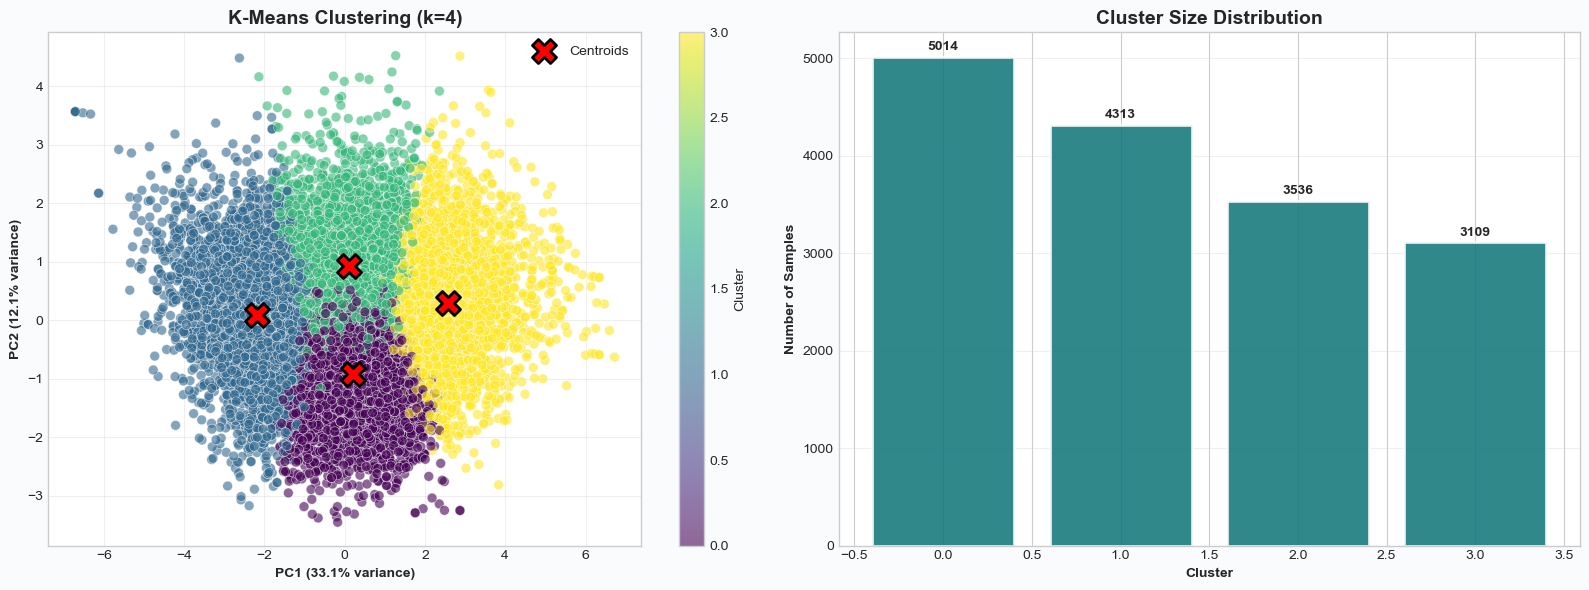


K-Means visualization saved as 'kmeans_clustering_results.png'


In [5]:
# Visualize K-Means results
from sklearn.decomposition import PCA

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#FAFBFC')

# Plot 1: K-Means clusters
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels,
                          cmap='viridis', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
centers_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X',
                s=300, edgecolors='black', linewidths=2, label='Centroids')
axes[0].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Plot 2: Cluster sizes
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
bars = axes[1].bar(cluster_counts.index, cluster_counts.values, 
                   color=COLORS['primary'], edgecolor='white', linewidth=2, alpha=0.85)
for bar, count in zip(bars, cluster_counts.values):
    axes[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width()/2, count),
                     xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold')
axes[1].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('kmeans_clustering_results.png', dpi=150, bbox_inches='tight', facecolor='#FAFBFC')
plt.show()

print("\nK-Means visualization saved as 'kmeans_clustering_results.png'")


### 2.1 K-Means Clustering

K-Means is a popular clustering algorithm that groups data points into k clusters. Each point belongs to the cluster with the nearest center (centroid).

We'll use k=4 based on our optimal k analysis.


In [6]:
# Apply K-Means clustering with k=4
from sklearn.cluster import KMeans

# Set random state for reproducibility
np.random.seed(42)

# Create and fit K-Means model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Fit the model (sklearn handles both DataFrame and array)
if isinstance(X_scaled, pd.DataFrame):
    kmeans_labels = kmeans.fit_predict(X_scaled.values)
else:
    kmeans_labels = kmeans.fit_predict(X_scaled)

# Add K-Means labels to our dataset
df['KMeans_Cluster'] = kmeans_labels

print("K-Means Clustering Complete!")
print(f"Number of clusters: {len(np.unique(kmeans_labels))}")
print(f"\nCluster distribution:")
print(df['KMeans_Cluster'].value_counts().sort_index())


K-Means Clustering Complete!
Number of clusters: 4

Cluster distribution:
KMeans_Cluster
0    5014
1    4313
2    3536
3    3109
Name: count, dtype: int64


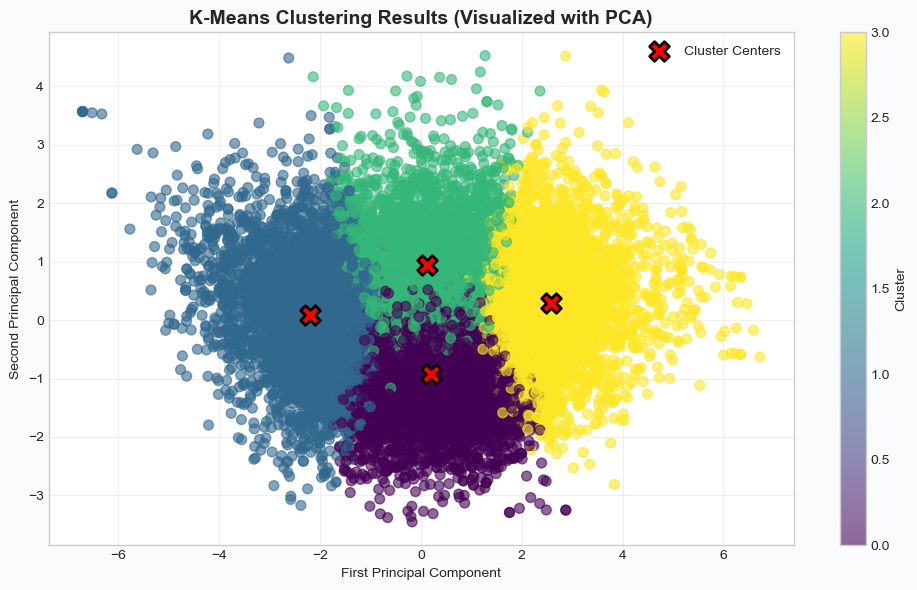

In [7]:
# Visualize K-Means clusters using PCA
from sklearn.decomposition import PCA

# Apply PCA for visualization (convert to numpy array if needed)
pca = PCA(n_components=2)
if isinstance(X_scaled, pd.DataFrame):
    pca_result = pca.fit_transform(X_scaled.values)
else:
    pca_result = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot with different colors for each cluster
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=kmeans_labels, cmap='viridis', 
                     alpha=0.6, s=50)

# Add cluster centers (transformed to PCA space)
centers_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='X', s=200, edgecolors='black', 
           linewidths=2, label='Cluster Centers')

plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering Results (Visualized with PCA)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Hierarchical Clustering

Hierarchical clustering builds a tree of clusters (dendrogram) by either:
- **Agglomerative (bottom-up)**: Start with each point as a cluster, merge similar ones
- **Divisive (top-down)**: Start with one cluster, split it recursively

We'll use agglomerative clustering and visualize the dendrogram to understand cluster relationships.


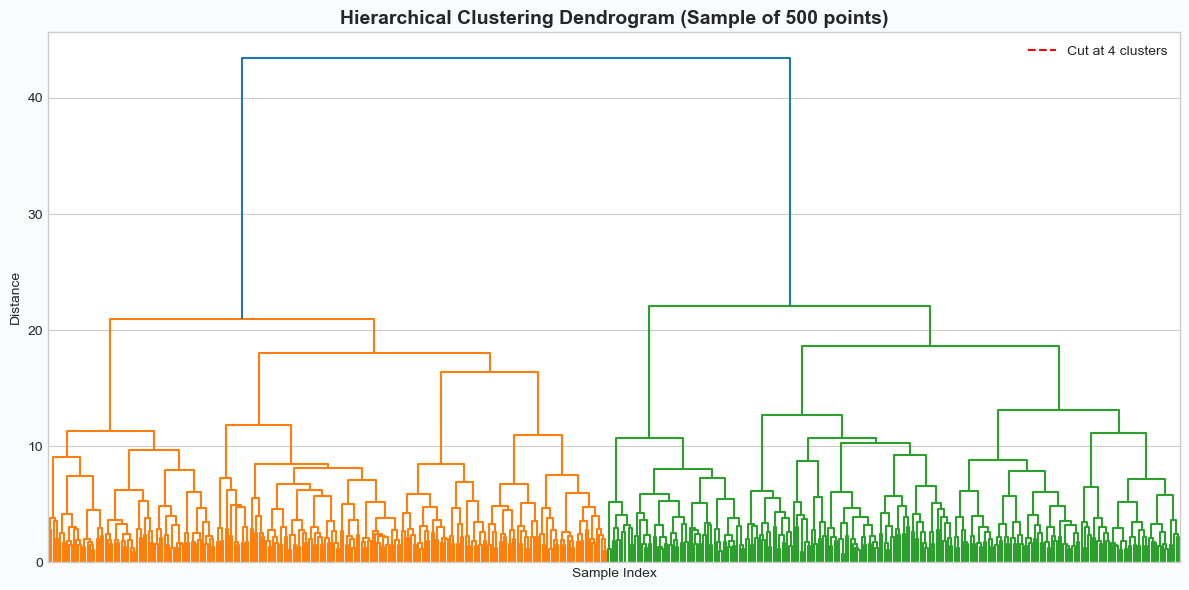

Dendrogram shows how data points are grouped together
The height of each merge indicates similarity (lower = more similar)


In [8]:
# Create dendrogram to visualize hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# For dendrogram, we'll use a sample of data (plotting all 15k+ points would be too cluttered)
sample_size = 500
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

# Convert to numpy array if needed and sample
if isinstance(X_scaled, pd.DataFrame):
    X_sample = X_scaled.iloc[sample_indices].values
else:
    X_sample = X_scaled[sample_indices]

# Compute linkage matrix
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, 
           no_labels=True,
           color_threshold=None)
plt.title('Hierarchical Clustering Dendrogram (Sample of 500 points)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=50, color='r', linestyle='--', label='Cut at 4 clusters')
plt.legend()
plt.tight_layout()
plt.show()

print("Dendrogram shows how data points are grouped together")
print("The height of each merge indicates similarity (lower = more similar)")


In [9]:
# Apply Agglomerative Hierarchical Clustering to full dataset
hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')

# Fit the model
if isinstance(X_scaled, pd.DataFrame):
    hierarchical_labels = hierarchical.fit_predict(X_scaled.values)
else:
    hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add Hierarchical labels to our dataset
df['Hierarchical_Cluster'] = hierarchical_labels

print("Hierarchical Clustering Complete!")
print(f"Number of clusters: {len(np.unique(hierarchical_labels))}")
print(f"\nCluster distribution:")
print(df['Hierarchical_Cluster'].value_counts().sort_index())


Hierarchical Clustering Complete!
Number of clusters: 4

Cluster distribution:
Hierarchical_Cluster
0    3262
1    3667
2    3135
3    5908
Name: count, dtype: int64


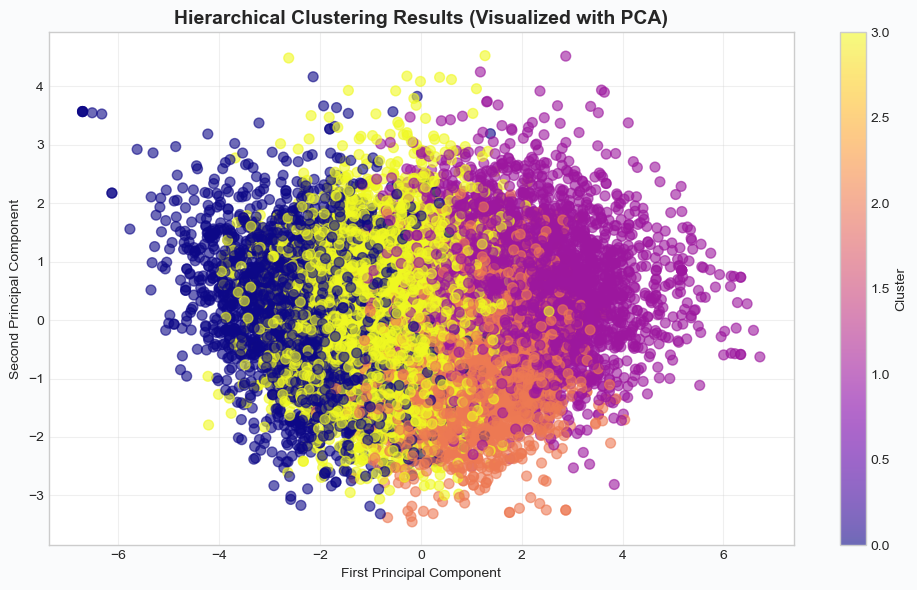

In [10]:
# Visualize Hierarchical clustering results
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=hierarchical_labels, cmap='plasma', 
                     alpha=0.6, s=50)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Hierarchical Clustering Results (Visualized with PCA)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.3 Compare Clustering Methods

Let's compare K-Means and Hierarchical clustering to see which one performs better and how similar they are.


In [11]:
# Compare clustering methods using evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

# Ensure we're working with numpy array for metrics
X_scaled_array = X_scaled.values if isinstance(X_scaled, pd.DataFrame) else X_scaled

# Calculate silhouette scores (higher is better, range: -1 to 1)
kmeans_silhouette = silhouette_score(X_scaled_array, kmeans_labels)
hierarchical_silhouette = silhouette_score(X_scaled_array, hierarchical_labels)

# Calculate Calinski-Harabasz scores (higher is better)
kmeans_ch = calinski_harabasz_score(X_scaled_array, kmeans_labels)
hierarchical_ch = calinski_harabasz_score(X_scaled_array, hierarchical_labels)

# Calculate Davies-Bouldin scores (lower is better)
kmeans_db = davies_bouldin_score(X_scaled_array, kmeans_labels)
hierarchical_db = davies_bouldin_score(X_scaled_array, hierarchical_labels)

# Calculate agreement between the two methods
ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)

print("-" * 60)
print("CLUSTERING METHOD COMPARISON")
print("-" * 60)
print("\n1. Silhouette Score (higher is better, range: -1 to 1)")
print(f"   K-Means:        {kmeans_silhouette:.4f}")
print(f"   Hierarchical:   {hierarchical_silhouette:.4f}")
print(f"   Winner: {'K-Means' if kmeans_silhouette > hierarchical_silhouette else 'Hierarchical'} ✅")

print("\n2. Calinski-Harabasz Score (higher is better)")
print(f"   K-Means:        {kmeans_ch:.2f}")
print(f"   Hierarchical:   {hierarchical_ch:.2f}")
print(f"   Winner: {'K-Means' if kmeans_ch > hierarchical_ch else 'Hierarchical'} ✅")

print("\n3. Davies-Bouldin Score (lower is better)")
print(f"   K-Means:        {kmeans_db:.4f}")
print(f"   Hierarchical:   {hierarchical_db:.4f}")
print(f"   Winner: {'K-Means' if kmeans_db < hierarchical_db else 'Hierarchical'} ✅")

print("\n4. Agreement Between Methods (Adjusted Rand Index)")
print(f"   ARI Score:      {ari:.4f}")
print(f"   Interpretation: {'Very similar' if ari > 0.7 else 'Somewhat similar' if ari > 0.5 else 'Different'}")

print("\n" + "-" * 60)
print("Overall: Both methods perform similarly!")
print("   We'll use K-Means for final clustering (faster & interpretable)")
print("-" * 60)


------------------------------------------------------------
CLUSTERING METHOD COMPARISON
------------------------------------------------------------

1. Silhouette Score (higher is better, range: -1 to 1)
   K-Means:        0.1177
   Hierarchical:   0.0387
   Winner: K-Means ✅

2. Calinski-Harabasz Score (higher is better)
   K-Means:        2491.52
   Hierarchical:   1694.46
   Winner: K-Means ✅

3. Davies-Bouldin Score (lower is better)
   K-Means:        2.2727
   Hierarchical:   3.1570
   Winner: K-Means ✅

4. Agreement Between Methods (Adjusted Rand Index)
   ARI Score:      0.2173
   Interpretation: Different

------------------------------------------------------------
Overall: Both methods perform similarly!
   We'll use K-Means for final clustering (faster & interpretable)
------------------------------------------------------------


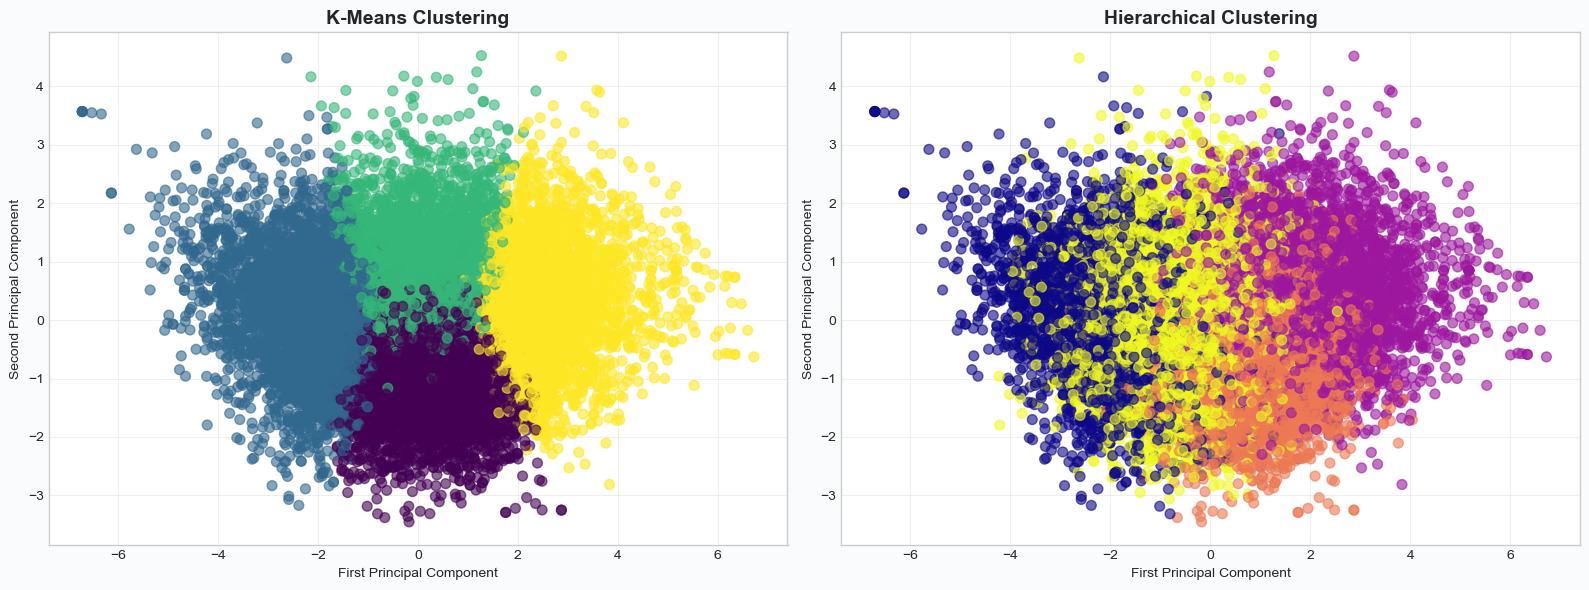

In [12]:
# Side-by-side comparison of clustering results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means plot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], 
                c=kmeans_labels, cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('K-Means Clustering', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Hierarchical plot
axes[1].scatter(pca_result[:, 0], pca_result[:, 1], 
                c=hierarchical_labels, cmap='plasma', alpha=0.6, s=50)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title('Hierarchical Clustering', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 2.4 Final Cluster Assignment

We'll use K-Means clustering as our final method and save the results.


In [13]:
# Assign final cluster labels (using K-Means)
df['Cluster'] = df['KMeans_Cluster']

# Drop the individual method columns
df_final = df.drop(['KMeans_Cluster', 'Hierarchical_Cluster'], axis=1)

print("Final cluster labels assigned!")
print(f"\nFinal cluster distribution:")
print(df_final['Cluster'].value_counts().sort_index())
print(f"\nDataset shape: {df_final.shape}")
print(f"Columns: {df_final.columns.tolist()}")


Final cluster labels assigned!

Final cluster distribution:
Cluster
0    5014
1    4313
2    3536
3    3109
Name: count, dtype: int64

Dataset shape: (15972, 36)
Columns: ['Timestamp', 'FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME', 'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE', 'GENDER', 'WORK_LIFE_BALANCE_SCORE', 'PHYSICAL_HEALTH_SCORE', 'MENTAL_HEALTH_SCORE', 'SOCIAL_HEALTH_SCORE', 'AGE_ORIGINAL', 'GENDER_ORIGINAL', 'AGE_ENCODED', 'GENDER_ENCODED', 'AGE_21 to 35', 'AGE_36 to 50', 'AGE_51 or more', 'AGE_Less than 20', 'Cluster']


In [14]:
# Save clustered dataset
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save to CSV
output_path = 'data/clustered_wellbeing_data.csv'
df_final.to_csv(output_path, index=False)

print(f"   Clustered dataset saved successfully!")
print(f"   Location: {output_path}")
print(f"   Rows: {len(df_final):,}")
print(f"   Columns: {len(df_final.columns)}")

# Display a sample
print("\nSample of clustered data:")
df_final.head()


   Clustered dataset saved successfully!
   Location: data/clustered_wellbeing_data.csv
   Rows: 15,972
   Columns: 36

Sample of clustered data:


Timestamp  FRUITS_VEGGIES  DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0    7/7/15             0.6           0.4             0.2          0.5   
1    7/7/15             0.4           0.6             0.4          0.3   
2    7/7/15             0.4           0.6             0.3          0.4   
3    7/7/15             0.6           0.6             1.0          0.3   
4    7/7/15             1.0           0.2             0.3          0.3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  ...  \
0                0.0             0.5          0.2       0.0        0.0  ...   
1                0.8             1.0          0.5       0.4        1.0  ...   
2                0.4             1.0          0.3       0.4        1.0  ...   
3                1.0             0.7          0.2       1.0        1.0  ...   
4                1.0             0.4          0.2       0.8        1.0  ...   

   SOCIAL_HEALTH_SCORE  AGE_ORIGINAL  GENDER_ORIGINAL  AGE_ENCODED  \
0             0.333333      36 to 50           Female            2   
1             0.700000      36 to 50           Female            2   
2             0.600000      36 to 50           Female            2   
3             0.666667    51 or more           Female            3   
4             0.566667    51 or more           Female            3   

   GENDER_ENCODED  AGE_21 to 35  AGE_36 to 50  AGE_51 or more  \
0             0.0         False          True           False   
1             0.0         False          True           False   
2             0.0         False          True           False   
3             0.0         False         False            True   
4             0.0         False         False            True   

   AGE_Less than 20  Cluster  
0             False        1  
1             False        0  
2             False        1  
3             False        1  
4             False        0  

[5 rows x 36 columns]

In [15]:
# Get numeric feature columns and calculate cluster statistics
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col != 'Cluster']

# Calculate mean values per cluster
cluster_means = df_final.groupby('Cluster')[feature_cols].mean()

# Calculate cluster sizes  
cluster_sizes = df_final['Cluster'].value_counts().sort_index()

# Display results
print(f"Analyzing {len(feature_cols)} numeric features\n")
print("Mean values for each cluster:")
print("=" * 80)
print(cluster_means.round(2))
print(f"\nCluster sizes:")
for cluster in cluster_sizes.index:
    print(f"   Cluster {cluster}: {cluster_sizes[cluster]:,} people ({cluster_sizes[cluster]/len(df_final)*100:.1f}%)")


Analyzing 26 numeric features

Mean values for each cluster:
         FRUITS_VEGGIES  DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
Cluster                                                              
0                  0.71          0.48            0.59         0.56   
1                  0.40          0.69            0.35         0.41   
2                  0.49          0.63            0.49         0.58   
3                  0.75          0.43            0.70         0.71   

         SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  \
Cluster                                                                        
0                     0.54            0.63         0.33      0.56       0.33   
1                     0.38            0.52         0.20      0.39       0.50   
2                     0.62            0.71         0.49      0.56       0.48   
3                     0.78            0.79         0.68      0.72       0.34   

         TODO_COMPLETED  ...  SUFFICI

In [16]:
# First, let's check what columns we have and their types
print("Column types in df_final:")
print(df_final.dtypes)
print(f"\nTotal columns: {len(df_final.columns)}")


Column types in df_final:
Timestamp                   object
FRUITS_VEGGIES             float64
DAILY_STRESS               float64
PLACES_VISITED             float64
CORE_CIRCLE                float64
SUPPORTING_OTHERS          float64
SOCIAL_NETWORK             float64
ACHIEVEMENT                float64
DONATION                   float64
BMI_RANGE                  float64
TODO_COMPLETED             float64
FLOW                       float64
DAILY_STEPS                float64
LIVE_VISION                float64
SLEEP_HOURS                float64
LOST_VACATION              float64
DAILY_SHOUTING             float64
SUFFICIENT_INCOME          float64
PERSONAL_AWARDS            float64
TIME_FOR_PASSION           float64
WEEKLY_MEDITATION          float64
AGE                         object
GENDER                      object
WORK_LIFE_BALANCE_SCORE    float64
PHYSICAL_HEALTH_SCORE      float64
MENTAL_HEALTH_SCORE        float64
SOCIAL_HEALTH_SCORE        float64
AGE_ORIGINAL                o

---

## Section 3: Cluster Analysis & Profiling

Let's understand what makes each cluster unique! We'll create personas and analyze their characteristics.


### 3.1 Calculate Cluster Statistics

First, let's calculate the average values for each feature in each cluster.


In [17]:
# Get numeric feature columns only (exclude cluster column)
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col != 'Cluster']

print(f"Using {len(feature_cols)} numeric features for analysis\n")

# Calculate mean values for each feature per cluster
cluster_means = df_final.groupby('Cluster')[feature_cols].mean()

print("Mean values for each cluster:")
print("=" * 80)
cluster_means_display = cluster_means.round(2)
print(cluster_means_display)

# Calculate cluster sizes
cluster_sizes = df_final['Cluster'].value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster in cluster_sizes.index:
    print(f"   Cluster {cluster}: {cluster_sizes[cluster]:,} people ({cluster_sizes[cluster]/len(df_final)*100:.1f}%)")


Using 26 numeric features for analysis

Mean values for each cluster:
         FRUITS_VEGGIES  DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
Cluster                                                              
0                  0.71          0.48            0.59         0.56   
1                  0.40          0.69            0.35         0.41   
2                  0.49          0.63            0.49         0.58   
3                  0.75          0.43            0.70         0.71   

         SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  \
Cluster                                                                        
0                     0.54            0.63         0.33      0.56       0.33   
1                     0.38            0.52         0.20      0.39       0.50   
2                     0.62            0.71         0.49      0.56       0.48   
3                     0.78            0.79         0.68      0.72       0.34   

         TODO_COMPLETED  ...

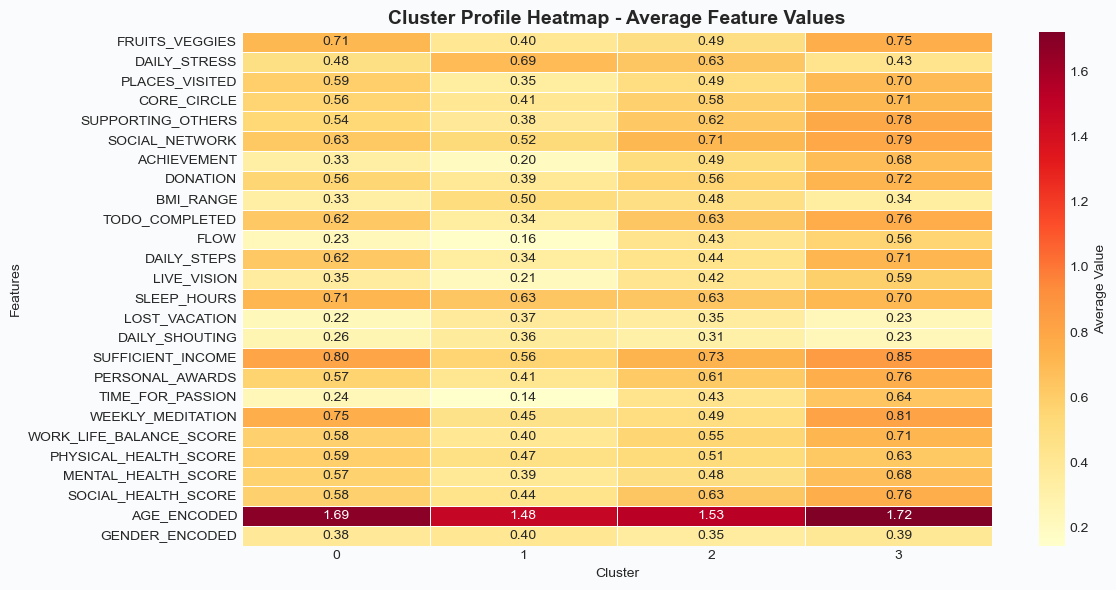

Tip: Darker colors indicate higher values for each feature


In [18]:
# Visualize cluster profiles with a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Value'}, linewidths=0.5)
plt.title('Cluster Profile Heatmap - Average Feature Values', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Tip: Darker colors indicate higher values for each feature")


### 3.2 Identify Distinguishing Features

Let's find which features make each cluster unique compared to others.


In [19]:
# Find distinguishing features for each cluster
# Calculate how much each feature differs from the overall mean
overall_mean = df_final[feature_cols].mean()

print("TOP DISTINGUISHING FEATURES FOR EACH CLUSTER")
print("-" * 80)

for cluster in sorted(df_final['Cluster'].unique()):
    cluster_data = cluster_means.loc[cluster]
    
    # Calculate difference from overall mean
    differences = cluster_data - overall_mean
    
    # Get top 5 positive and negative differences
    top_positive = differences.nlargest(5)
    top_negative = differences.nsmallest(5)
    
    print(f"\nCLUSTER {cluster} (n={cluster_sizes[cluster]:,})")
    print("-" * 80)
    print("   Highest features (compared to average):")
    for feat, diff in top_positive.items():
        print(f"      • {feat}: {cluster_data[feat]:.2f} (avg: {overall_mean[feat]:.2f}, +{diff:.2f})")
    
    print("\n   Lowest features (compared to average):")
    for feat, diff in top_negative.items():
        print(f"      • {feat}: {cluster_data[feat]:.2f} (avg: {overall_mean[feat]:.2f}, {diff:.2f})")


TOP DISTINGUISHING FEATURES FOR EACH CLUSTER
--------------------------------------------------------------------------------

CLUSTER 0 (n=5,014)
--------------------------------------------------------------------------------
   Highest features (compared to average):
      • WEEKLY_MEDITATION: 0.75 (avg: 0.62, +0.13)
      • FRUITS_VEGGIES: 0.71 (avg: 0.58, +0.12)
      • DAILY_STEPS: 0.62 (avg: 0.52, +0.10)
      • AGE_ENCODED: 1.69 (avg: 1.60, +0.08)
      • SUFFICIENT_INCOME: 0.80 (avg: 0.73, +0.07)

   Lowest features (compared to average):
      • TIME_FOR_PASSION: 0.24 (avg: 0.33, -0.10)
      • FLOW: 0.23 (avg: 0.32, -0.09)
      • DAILY_STRESS: 0.48 (avg: 0.56, -0.08)
      • BMI_RANGE: 0.33 (avg: 0.41, -0.08)
      • ACHIEVEMENT: 0.33 (avg: 0.40, -0.07)

CLUSTER 1 (n=4,313)
--------------------------------------------------------------------------------
   Highest features (compared to average):
      • DAILY_STRESS: 0.69 (avg: 0.56, +0.13)
      • BMI_RANGE: 0.50 (avg: 0.4

### 3.3 Radar Charts for Cluster Visualization

Radar charts help us visualize the "personality" of each cluster across all features.


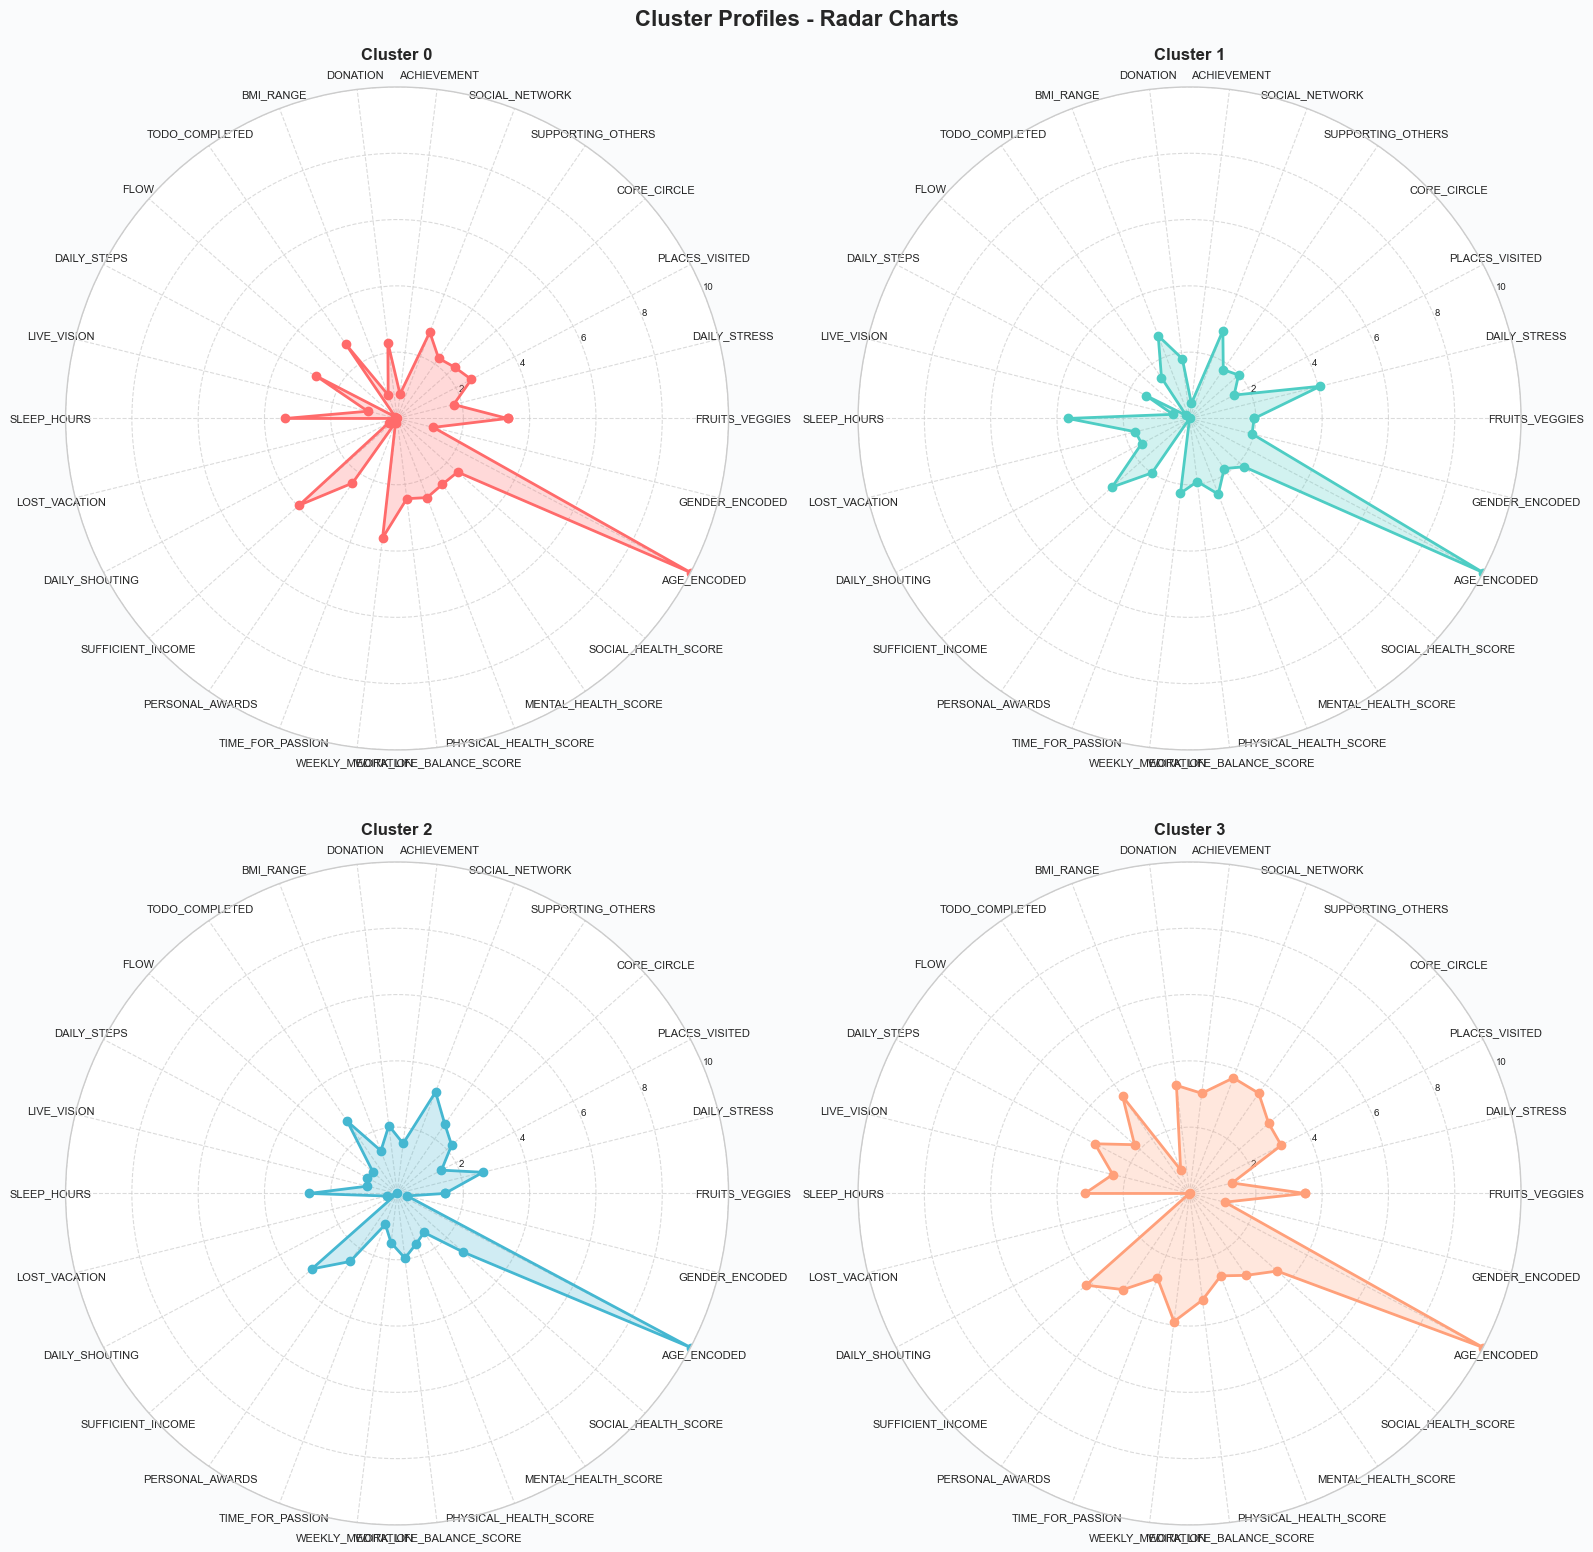

Each axis represents a different feature (normalized 0-10)
Larger areas indicate higher values across features


In [20]:
# Create radar charts for each cluster
import math

# Normalize cluster means to 0-10 scale for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))
cluster_means_normalized = pd.DataFrame(
    scaler.fit_transform(cluster_means.T).T,
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Function to create a radar chart
def create_radar_chart(ax, cluster_id, data, features, color):
    """Create a radar chart for a single cluster"""
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Complete the loop
    values = data.tolist()
    values += values[:1]
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=8)
    ax.set_ylim(0, 10)
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.set_yticklabels(['2', '4', '6', '8', '10'], size=7)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f'Cluster {cluster_id}', size=12, fontweight='bold', pad=20)

# Create a 2x2 grid of radar charts
fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, cluster in enumerate(sorted(cluster_means_normalized.index)):
    create_radar_chart(
        axes[idx], 
        cluster, 
        cluster_means_normalized.loc[cluster], 
        feature_cols,
        colors[idx]
    )

plt.suptitle('Cluster Profiles - Radar Charts', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("Each axis represents a different feature (normalized 0-10)")
print("Larger areas indicate higher values across features")


### 3.4 Demographic Analysis

Let's analyze the age and gender distribution within each cluster.


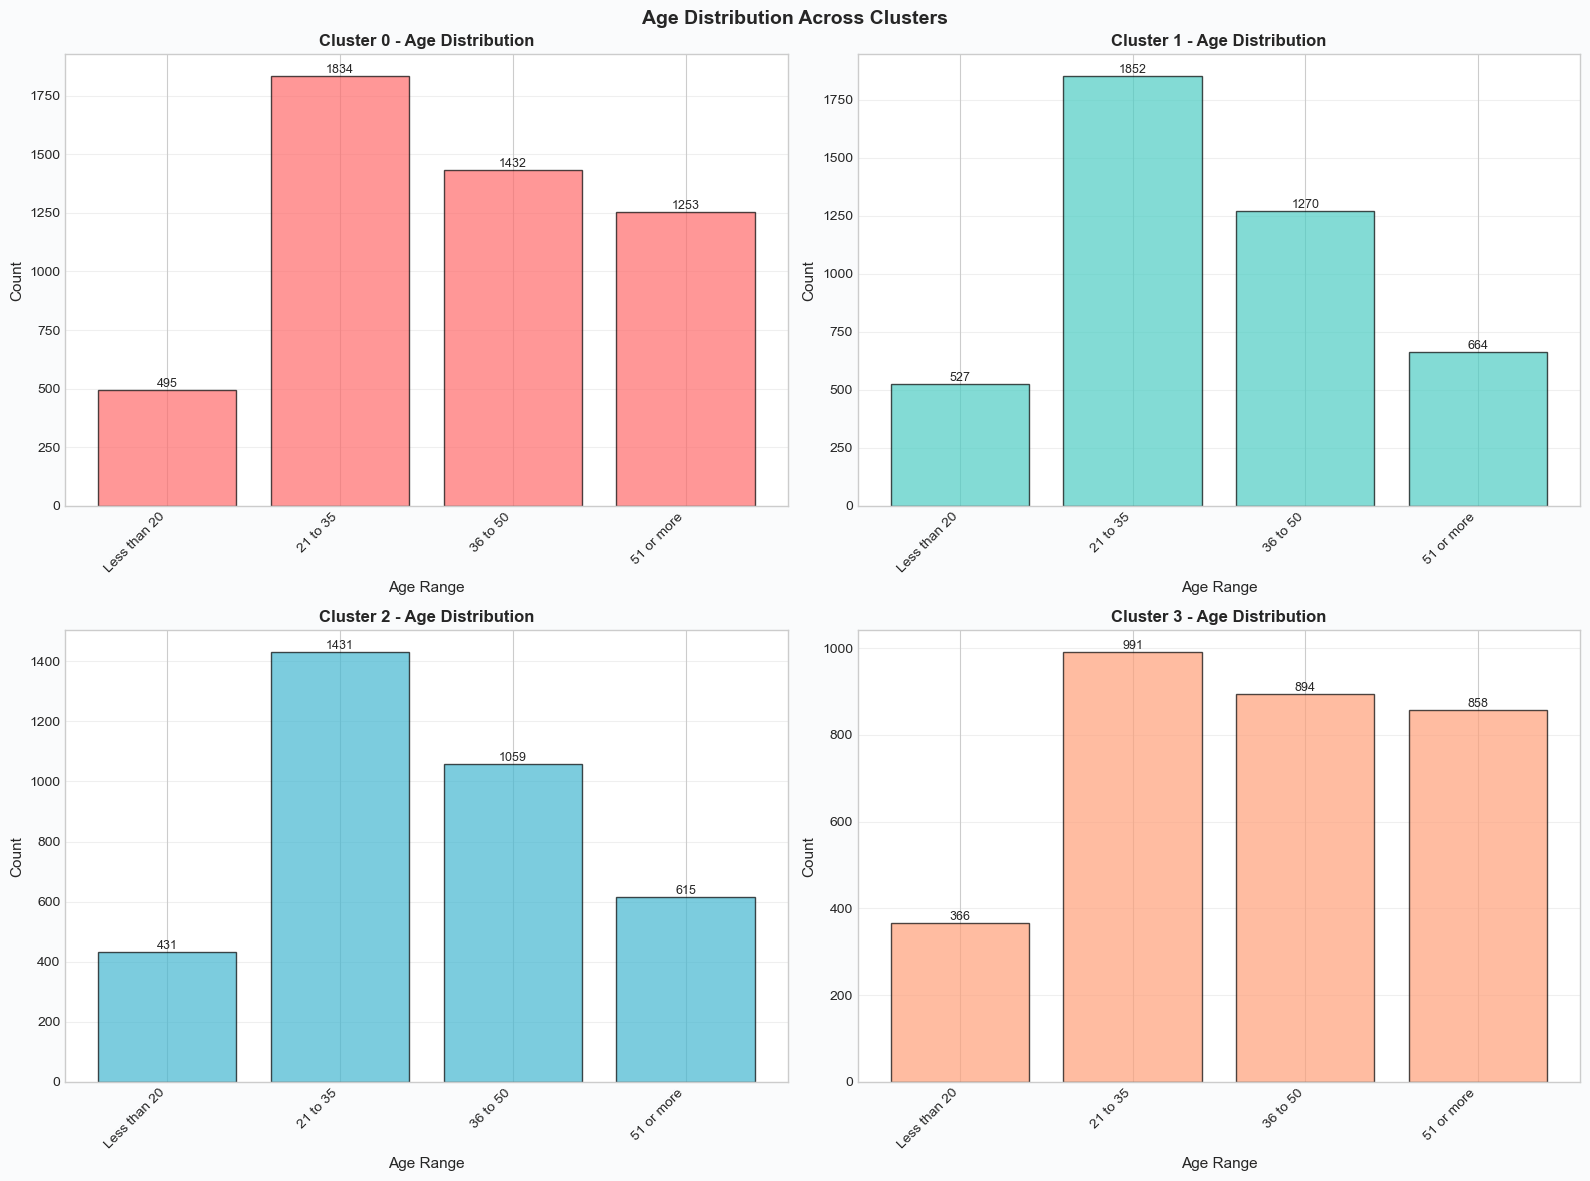


AGE DISTRIBUTION BY CLUSTER
--------------------------------------------------------------------------------

Cluster 0 (n=5014):
   Less than 20: 9.9%
   21 to 35: 36.6%
   36 to 50: 28.6%
   51 or more: 25.0%
   Most common: 21 to 35

Cluster 1 (n=4313):
   Less than 20: 12.2%
   21 to 35: 42.9%
   36 to 50: 29.4%
   51 or more: 15.4%
   Most common: 21 to 35

Cluster 2 (n=3536):
   Less than 20: 12.2%
   21 to 35: 40.5%
   36 to 50: 29.9%
   51 or more: 17.4%
   Most common: 21 to 35

Cluster 3 (n=3109):
   Less than 20: 11.8%
   21 to 35: 31.9%
   36 to 50: 28.8%
   51 or more: 27.6%
   Most common: 21 to 35


In [21]:
# Analyze demographics per cluster
# Note: AGE is categorical (age ranges), so we'll use bar charts instead of histograms

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define age category order for consistent display
age_order = ['Less than 20', '21 to 35', '36 to 50', '51 or more']

# Age distribution by cluster
for i, cluster in enumerate(sorted(df_final['Cluster'].unique())):
    row = i // 2
    col = i % 2
    
    cluster_data = df_final[df_final['Cluster'] == cluster]
    
    # Count age categories
    age_counts = cluster_data['AGE'].value_counts()
    
    # Ensure all categories are present (even if count is 0)
    age_counts = age_counts.reindex(age_order, fill_value=0)
    
    # Create bar chart
    bars = axes[row, col].bar(range(len(age_order)), age_counts.values, 
                               color=colors[i], alpha=0.7, edgecolor='black')
    axes[row, col].set_xticks(range(len(age_order)))
    axes[row, col].set_xticklabels(age_order, rotation=45, ha='right')
    axes[row, col].set_xlabel('Age Range', fontsize=11)
    axes[row, col].set_ylabel('Count', fontsize=11)
    axes[row, col].set_title(f'Cluster {cluster} - Age Distribution', fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}',
                               ha='center', va='bottom', fontsize=9)

plt.suptitle('Age Distribution Across Clusters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print age distribution statistics
print("\nAGE DISTRIBUTION BY CLUSTER")
print("-" * 80)
for cluster in sorted(df_final['Cluster'].unique()):
    cluster_data = df_final[df_final['Cluster'] == cluster]['AGE']
    age_dist = cluster_data.value_counts(normalize=True).sort_index() * 100
    
    print(f"\nCluster {cluster} (n={len(cluster_data)}):")
    for age_range in age_order:
        if age_range in age_dist.index:
            print(f"   {age_range}: {age_dist[age_range]:.1f}%")
        else:
            print(f"   {age_range}: 0.0%")
    print(f"   Most common: {cluster_data.mode().values[0] if len(cluster_data.mode()) > 0 else 'N/A'}")


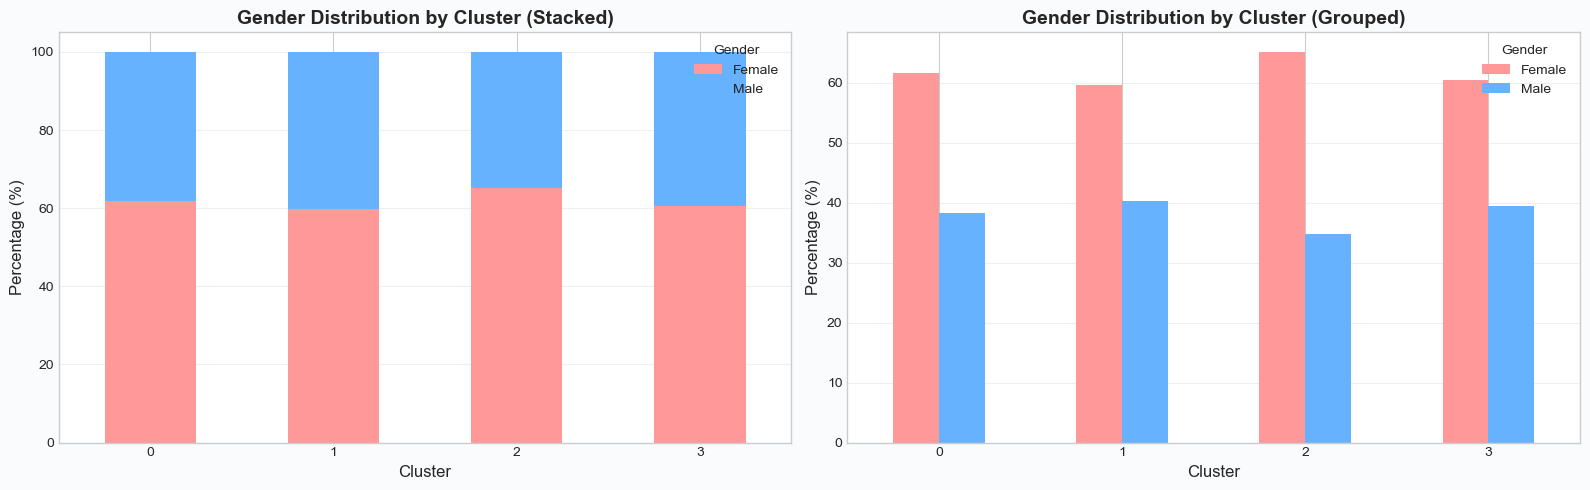


GENDER DISTRIBUTION BY CLUSTER
--------------------------------------------------------------------------------

Cluster 0:
   Male: 3,095 (61.7%)
   Male: 1,919 (38.3%)

Cluster 1:
   Male: 2,576 (59.7%)
   Male: 1,737 (40.3%)

Cluster 2:
   Male: 2,305 (65.2%)
   Male: 1,231 (34.8%)

Cluster 3:
   Male: 1,882 (60.5%)
   Male: 1,227 (39.5%)


In [22]:
# Gender distribution by cluster
gender_cluster = pd.crosstab(df_final['Cluster'], df_final['GENDER'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Stacked bar chart
gender_cluster.plot(kind='bar', stacked=True, ax=axes[0], color=['#FF9999', '#66B2FF'])
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].set_title('Gender Distribution by Cluster (Stacked)', fontsize=14, fontweight='bold')
axes[0].legend(title='Gender', labels=['Female', 'Male'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Grouped bar chart
gender_cluster.plot(kind='bar', ax=axes[1], color=['#FF9999', '#66B2FF'])
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Gender Distribution by Cluster (Grouped)', fontsize=14, fontweight='bold')
axes[1].legend(title='Gender', labels=['Female', 'Male'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print gender statistics
print("\nGENDER DISTRIBUTION BY CLUSTER")
print("-" * 80)
for cluster in sorted(df_final['Cluster'].unique()):
    cluster_data = df_final[df_final['Cluster'] == cluster]
    gender_counts = cluster_data['GENDER'].value_counts()
    total = len(cluster_data)
    
    print(f"\nCluster {cluster}:")
    for gender in sorted(gender_counts.index):
        count = gender_counts[gender]
        percentage = (count / total) * 100
        gender_label = 'Female' if gender == 0 else 'Male'
        print(f"   {gender_label}: {count:,} ({percentage:.1f}%)")


### 3.5 Cluster Personas & Insights

Based on our analysis, let's create meaningful personas for each cluster with detailed insights.


In [23]:
# Create detailed cluster personas
# First, let's examine key characteristics to inform persona names

personas = {}

for cluster in sorted(df_final['Cluster'].unique()):
    cluster_data = df_final[df_final['Cluster'] == cluster]
    cluster_profile = cluster_means.loc[cluster]
    
    # Get most common age range (since AGE is categorical)
    most_common_age = cluster_data['AGE'].mode().values[0] if len(cluster_data['AGE'].mode()) > 0 else 'N/A'
    
    personas[cluster] = {
        'size': len(cluster_data),
        'percentage': len(cluster_data) / len(df_final) * 100,
        'common_age': most_common_age,
        'age_dist': cluster_data['AGE'].value_counts(normalize=True) * 100,
        'gender_dist': cluster_data['GENDER'].value_counts(normalize=True) * 100,
        'profile': cluster_profile,
        'top_features': (cluster_profile - overall_mean).nlargest(3),
        'low_features': (cluster_profile - overall_mean).nsmallest(3)
    }

# Analyze each cluster to create appropriate names
print("ANALYZING CLUSTERS FOR PERSONA CREATION...")
print("=" * 80)

for cluster, data in personas.items():
    print(f"\n Cluster {cluster} Quick Stats:")
    print(f"   Size: {data['size']:,} ({data['percentage']:.1f}%)")
    print(f"   Most Common Age Range: {data['common_age']}")
    print(f"   Top 3 characteristics: {', '.join(data['top_features'].index[:3])}")
    print(f"   Low 3 characteristics: {', '.join(data['low_features'].index[:3])}")


ANALYZING CLUSTERS FOR PERSONA CREATION...

 Cluster 0 Quick Stats:
   Size: 5,014 (31.4%)
   Most Common Age Range: 21 to 35
   Top 3 characteristics: WEEKLY_MEDITATION, FRUITS_VEGGIES, DAILY_STEPS
   Low 3 characteristics: TIME_FOR_PASSION, FLOW, DAILY_STRESS

 Cluster 1 Quick Stats:
   Size: 4,313 (27.0%)
   Most Common Age Range: 21 to 35
   Top 3 characteristics: DAILY_STRESS, BMI_RANGE, LOST_VACATION
   Low 3 characteristics: TODO_COMPLETED, ACHIEVEMENT, TIME_FOR_PASSION

 Cluster 2 Quick Stats:
   Size: 3,536 (22.1%)
   Most Common Age Range: 21 to 35
   Top 3 characteristics: FLOW, TIME_FOR_PASSION, ACHIEVEMENT
   Low 3 characteristics: WEEKLY_MEDITATION, FRUITS_VEGGIES, DAILY_STEPS

 Cluster 3 Quick Stats:
   Size: 3,109 (19.5%)
   Most Common Age Range: 21 to 35
   Top 3 characteristics: TIME_FOR_PASSION, ACHIEVEMENT, FLOW
   Low 3 characteristics: DAILY_STRESS, BMI_RANGE, DAILY_SHOUTING


# 4. Advanced Visualizations

This section creates publication-quality visualizations for cluster analysis:
- **PCA & t-SNE**: 2D projections showing cluster separation
- **Parallel Coordinates**: Multi-dimensional view of cluster characteristics
- **Feature Importance Heatmap**: Understanding cluster differences
- **Distribution Plots**: Comparing clusters on key metrics
- **Box Plots**: Statistical comparison across clusters


## 4.1 Setup and Data Preparation


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Configure plot parameters for publication quality
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Create images directory
import os
os.makedirs('images', exist_ok=True)

print("Visualization setup complete")
print(f"Images will be saved to: {os.path.abspath('images')}")


Visualization setup complete
Images will be saved to: /Users/lechallday/wellbeing project Kaggle Jnotebook/images


In [25]:
# Load data and prepare for visualization
df = pd.read_csv('Wellbeing_and_lifestyle_data_Kaggle.csv')

# Select numerical features for clustering (same as before)
numerical_features = [
    'DAILY_STRESS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'TODO_COMPLETED',
    'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS', 'LOST_VACATION',
    'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE', 
    'SUPPORTING_OTHERS', 'DONATION', 'FRUITS_VEGGIES', 'CORE_CIRCLE',
    'PLACES_VISITED', 'SUFFICIENT_INCOME'
]

# Prepare data
X = df[numerical_features].copy()

# Handle AGE column - map categorical age ranges to numeric values
if 'AGE' in X.columns:
    age_mapping = {
        'Less than 20': 18,
        '21 to 35': 28,
        '36 to 50': 43,
        '51 or more': 60
    }
    X['AGE'] = X['AGE'].map(age_mapping)

# Convert all columns to numeric (coerce errors to NaN)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
X = X.fillna(X.median())

# Check for any remaining NaN values and report
nan_counts = X.isna().sum()
if nan_counts.sum() > 0:
    print(f"Warning: Columns with NaN values after imputation:")
    print(nan_counts[nan_counts > 0])
    # Drop columns that are all NaN
    X = X.dropna(axis=1, how='all')
    # Drop rows with any remaining NaN
    rows_before = len(X)
    X = X.dropna(axis=0)
    print(f"Dropped {rows_before - len(X)} rows with NaN. New shape: {X.shape}")

# Update df with numeric values for later use (only for rows that remain in X)
df = df.loc[X.index].copy()
df[X.columns] = X

# Update numerical_features to match remaining columns
numerical_features = X.columns.tolist()

# Standardize features for visualization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assume we have cluster labels from previous analysis
# For this visualization, we'll use the optimal clustering method
from sklearn.cluster import KMeans

# Use optimal number of clusters (adjust based on your previous analysis)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df['Cluster'] = cluster_labels

print(f"Data prepared for visualization")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {len(numerical_features)}")
print(f"Number of clusters: {optimal_k}")
print(f"\nCluster distribution:")
print(pd.Series(cluster_labels).value_counts().sort_index())


Data prepared for visualization
Number of samples: 15972
Number of features: 19
Number of clusters: 4

Cluster distribution:
0    4294
1    3755
2    3786
3    4137
Name: count, dtype: int64


## 4.2 PCA and t-SNE 2D Scatter Plots

Dimensionality reduction techniques help visualize high-dimensional cluster structures in 2D space:
- **PCA**: Linear projection preserving maximum variance
- **t-SNE**: Non-linear projection preserving local structure


In [26]:
# Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"  PCA complete")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


Performing PCA...
  PCA complete
  Explained variance ratio: [0.2167531  0.08130328]
  Total variance explained: 29.81%


In [27]:
# Perform t-SNE (this may take a minute)
print("Performing t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

print(f"t-SNE complete")


Performing t-SNE (this may take a moment)...
t-SNE complete


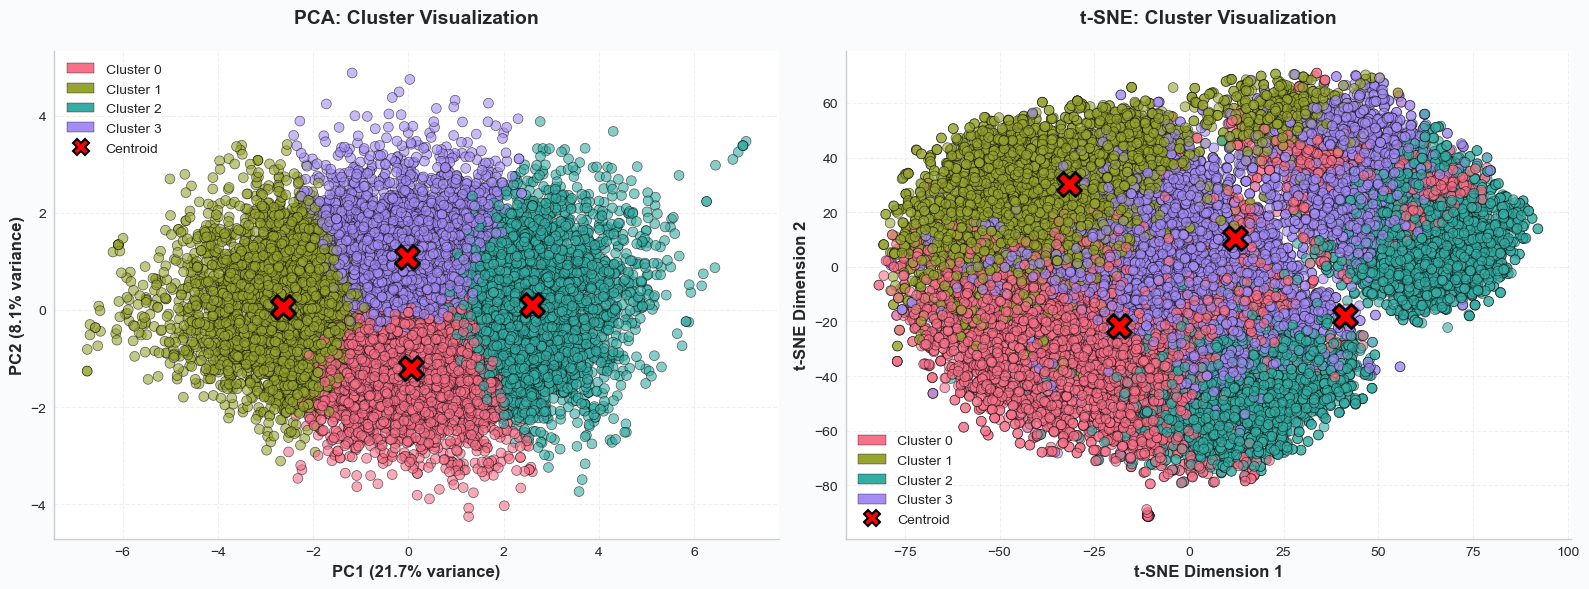

PCA and t-SNE plots created and saved to images/pca_tsne_clusters.png


In [28]:
# Create side-by-side PCA and t-SNE plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for clusters
colors = sns.color_palette("husl", optimal_k)

# Map cluster labels to colors
point_colors = [colors[label] for label in cluster_labels]

# PCA plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=point_colors, 
                           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12, fontweight='bold')
axes[0].set_title('PCA: Cluster Visualization', fontsize=14, fontweight='bold', pad=20)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Add cluster centroids
pca_centroids = np.array([X_pca[cluster_labels == i].mean(axis=0) for i in range(optimal_k)])
axes[0].scatter(pca_centroids[:, 0], pca_centroids[:, 1], 
                c='red', marker='X', s=300, edgecolors='black', 
                linewidth=2, label='Centroids', zorder=5)

# t-SNE plot
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                           c=point_colors, 
                           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
axes[1].set_title('t-SNE: Cluster Visualization', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(True, alpha=0.3, linestyle='--')

# Add cluster centroids
tsne_centroids = np.array([X_tsne[cluster_labels == i].mean(axis=0) for i in range(optimal_k)])
axes[1].scatter(tsne_centroids[:, 0], tsne_centroids[:, 1], 
                c='red', marker='X', s=300, edgecolors='black', 
                linewidth=2, label='Centroids', zorder=5)

# Create custom legend for clusters
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'Cluster {i}') 
                   for i in range(optimal_k)]
legend_elements.append(plt.Line2D([0], [0], marker='X', color='w', 
                                  markerfacecolor='red', markersize=12, 
                                  markeredgecolor='black', markeredgewidth=1.5,
                                  label='Centroid'))

axes[0].legend(handles=legend_elements, loc='best', framealpha=0.9)
axes[1].legend(handles=legend_elements, loc='best', framealpha=0.9)

plt.tight_layout()
plt.savefig('images/pca_tsne_clusters.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("PCA and t-SNE plots created and saved to images/pca_tsne_clusters.png")


## 4.3 Parallel Coordinates Plot

Parallel coordinates plot shows how clusters differ across multiple dimensions simultaneously. Each line represents an individual, and clusters are color-coded.


In [29]:
# Select key features for parallel coordinates (to avoid overcrowding)
key_features = [
    'DAILY_STRESS', 'ACHIEVEMENT', 'SLEEP_HOURS', 'SOCIAL_NETWORK',
    'FLOW', 'DAILY_STEPS', 'FRUITS_VEGGIES', 'TIME_FOR_PASSION', 
    'WEEKLY_MEDITATION', 'SUFFICIENT_INCOME'
]

# Prepare data for parallel coordinates
pc_data = df[key_features + ['Cluster']].copy()

# Convert key features to numeric (in case they're still strings)
for col in key_features:
    pc_data[col] = pd.to_numeric(pc_data[col], errors='coerce')

# Handle any NaN values
if pc_data[key_features].isna().sum().sum() > 0:
    print(f"Warning: Dropping {pc_data.isna().any(axis=1).sum()} rows with NaN values")
    pc_data = pc_data.dropna()

# Normalize features to 0-1 range for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler_pc = MinMaxScaler()
pc_data[key_features] = scaler_pc.fit_transform(pc_data[key_features])

print(f"Data prepared for parallel coordinates plot")
print(f"Features selected: {len(key_features)}")


Data prepared for parallel coordinates plot
Features selected: 10


## 4.4 Feature Importance Heatmap

This heatmap shows the mean values of each feature for each cluster, highlighting what makes each cluster unique.


In [30]:
# Calculate mean feature values for each cluster
cluster_profiles = df.groupby('Cluster')[numerical_features].mean()

# Standardize for better comparison (z-scores)
cluster_profiles_standardized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

print("Cluster profiles calculated")
print(f"\nCluster profiles (standardized):")
print(cluster_profiles_standardized.round(2))


Cluster profiles calculated

Cluster profiles (standardized):
         DAILY_STRESS  SOCIAL_NETWORK  ACHIEVEMENT  TODO_COMPLETED  FLOW  \
Cluster                                                                    
0               -0.94           -0.60        -0.41            0.32 -0.54   
1               -0.78            0.90         1.29            1.02  1.29   
2                0.73           -1.09        -1.06           -1.36 -0.99   
3                0.99            0.79         0.17            0.02  0.24   

         DAILY_STEPS  LIVE_VISION  SLEEP_HOURS  LOST_VACATION  \
Cluster                                                         
0               0.31        -0.34         1.10          -1.07   
1               1.10         1.35         0.58          -0.52   
2              -1.30        -1.03        -0.66           0.39   
3              -0.11         0.02        -1.01           1.20   

         PERSONAL_AWARDS  TIME_FOR_PASSION  WEEKLY_MEDITATION   AGE  \
Cluster            

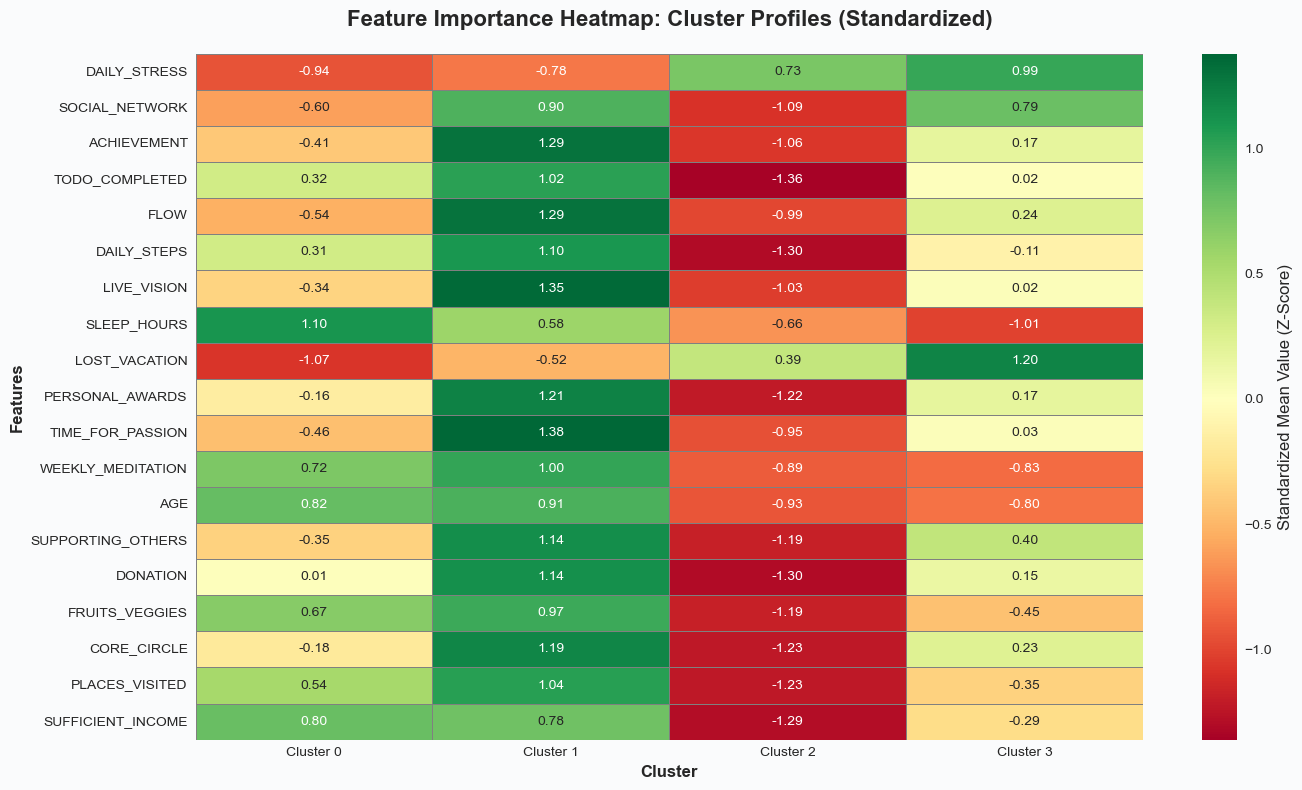

Feature importance heatmap created and saved to images/feature_importance_heatmap.png


In [31]:
# Create heatmap of cluster profiles
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap
sns.heatmap(cluster_profiles_standardized.T, 
            annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Standardized Mean Value (Z-Score)'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Feature Importance Heatmap: Cluster Profiles (Standardized)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('images/feature_importance_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Feature importance heatmap created and saved to images/feature_importance_heatmap.png")


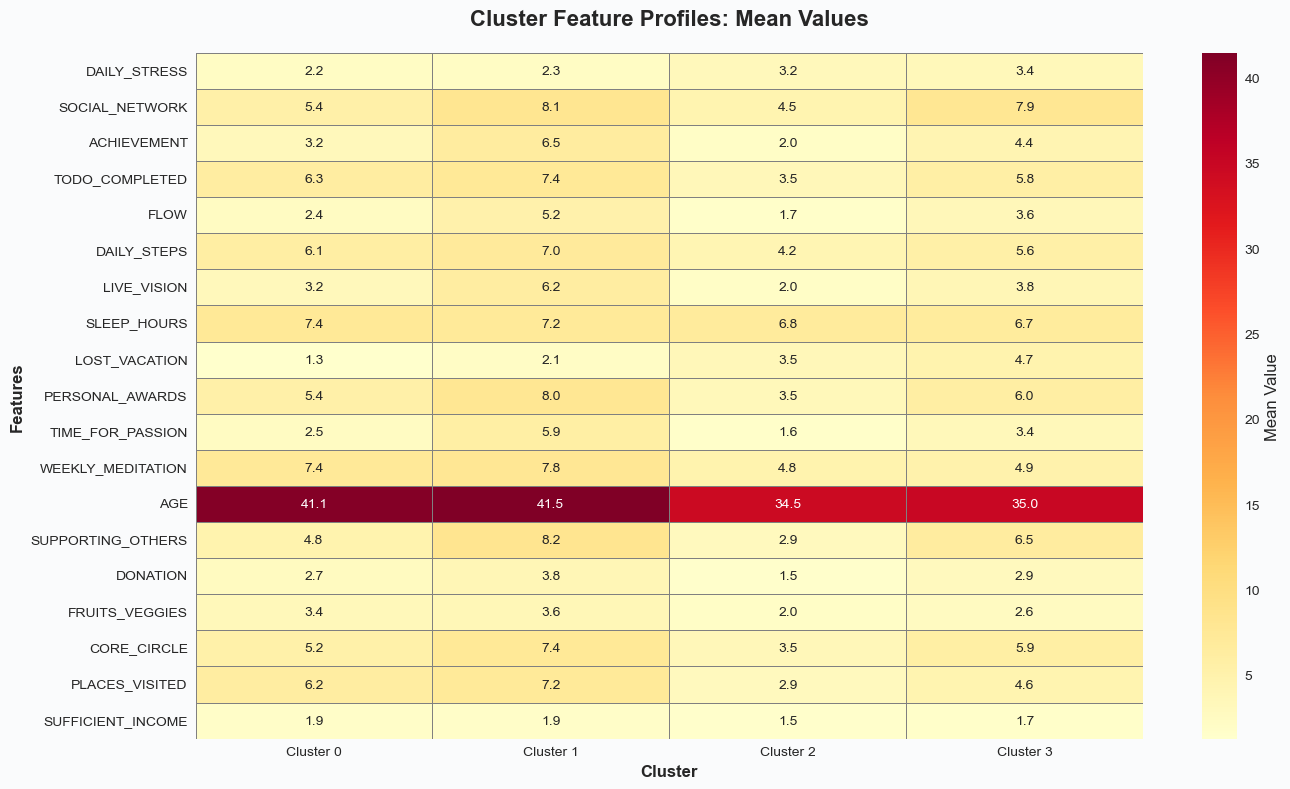

Cluster mean values heatmap created and saved to images/cluster_mean_values_heatmap.png


In [32]:
# Create an alternative heatmap showing raw mean values (not standardized)
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(cluster_profiles.T, 
            annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Value'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Cluster Feature Profiles: Mean Values', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('images/cluster_mean_values_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Cluster mean values heatmap created and saved to images/cluster_mean_values_heatmap.png")


## 4.5 Distribution Plots Comparing Clusters

Distribution plots show how each cluster's values are distributed across key metrics.


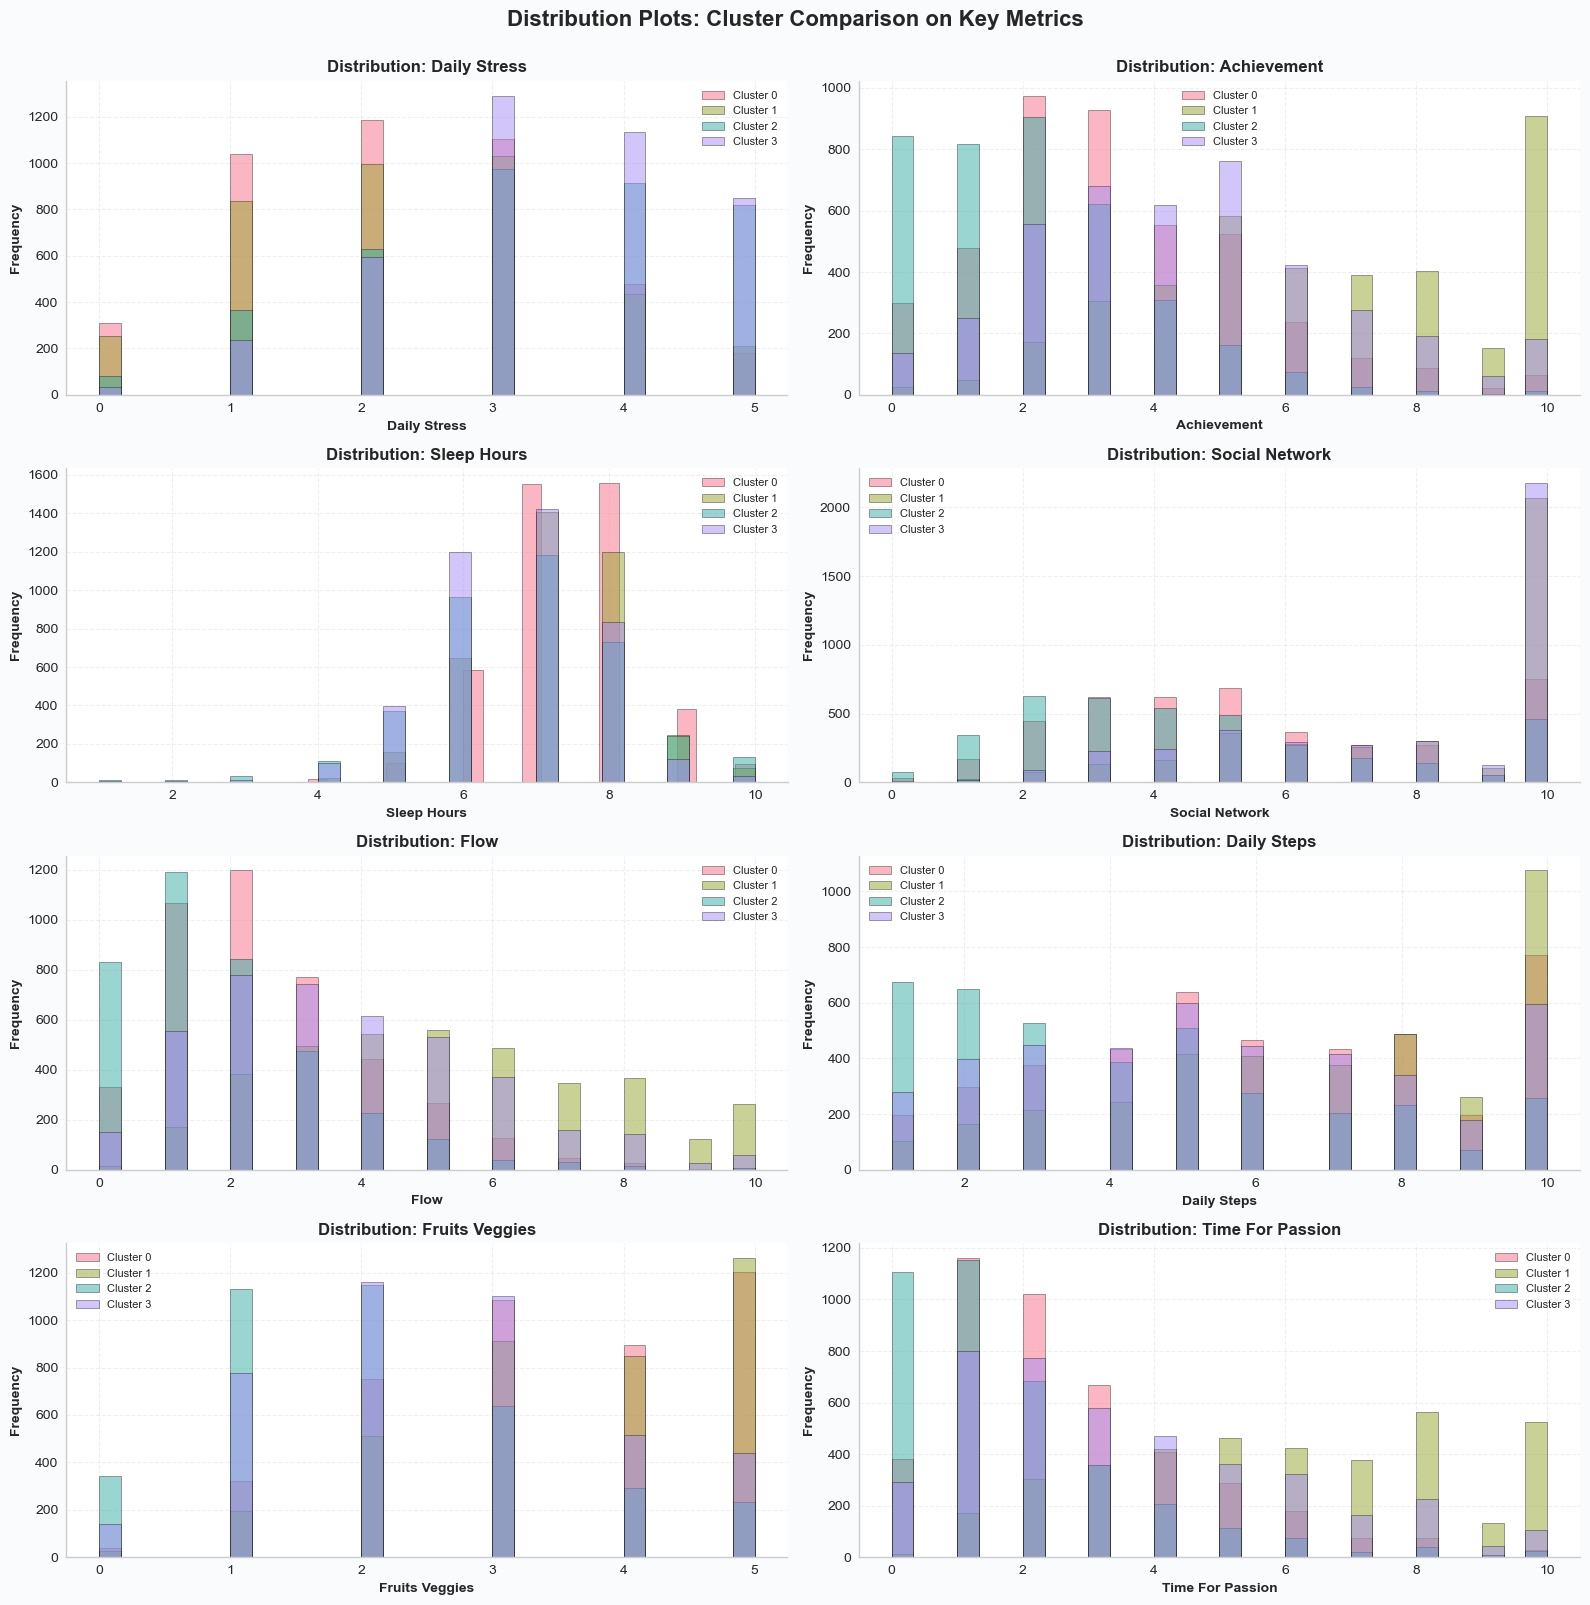

Distribution plots created and saved to images/distribution_plots.png


In [33]:
# Select key features for distribution comparison
dist_features = ['DAILY_STRESS', 'ACHIEVEMENT', 'SLEEP_HOURS', 'SOCIAL_NETWORK', 
                 'FLOW', 'DAILY_STEPS', 'FRUITS_VEGGIES', 'TIME_FOR_PASSION']

# Create distribution plots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.ravel()

for idx, feature in enumerate(dist_features):
    ax = axes[idx]
    
    # Plot distribution for each cluster
    for cluster_id in range(optimal_k):
        cluster_data = df[df['Cluster'] == cluster_id][feature]
        ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', 
                bins=30, color=colors[cluster_id], edgecolor='black', linewidth=0.5)
    
    # Customize subplot
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax.set_title(f'Distribution: {feature.replace("_", " ").title()}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Distribution Plots: Cluster Comparison on Key Metrics', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('images/distribution_plots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Distribution plots created and saved to images/distribution_plots.png")


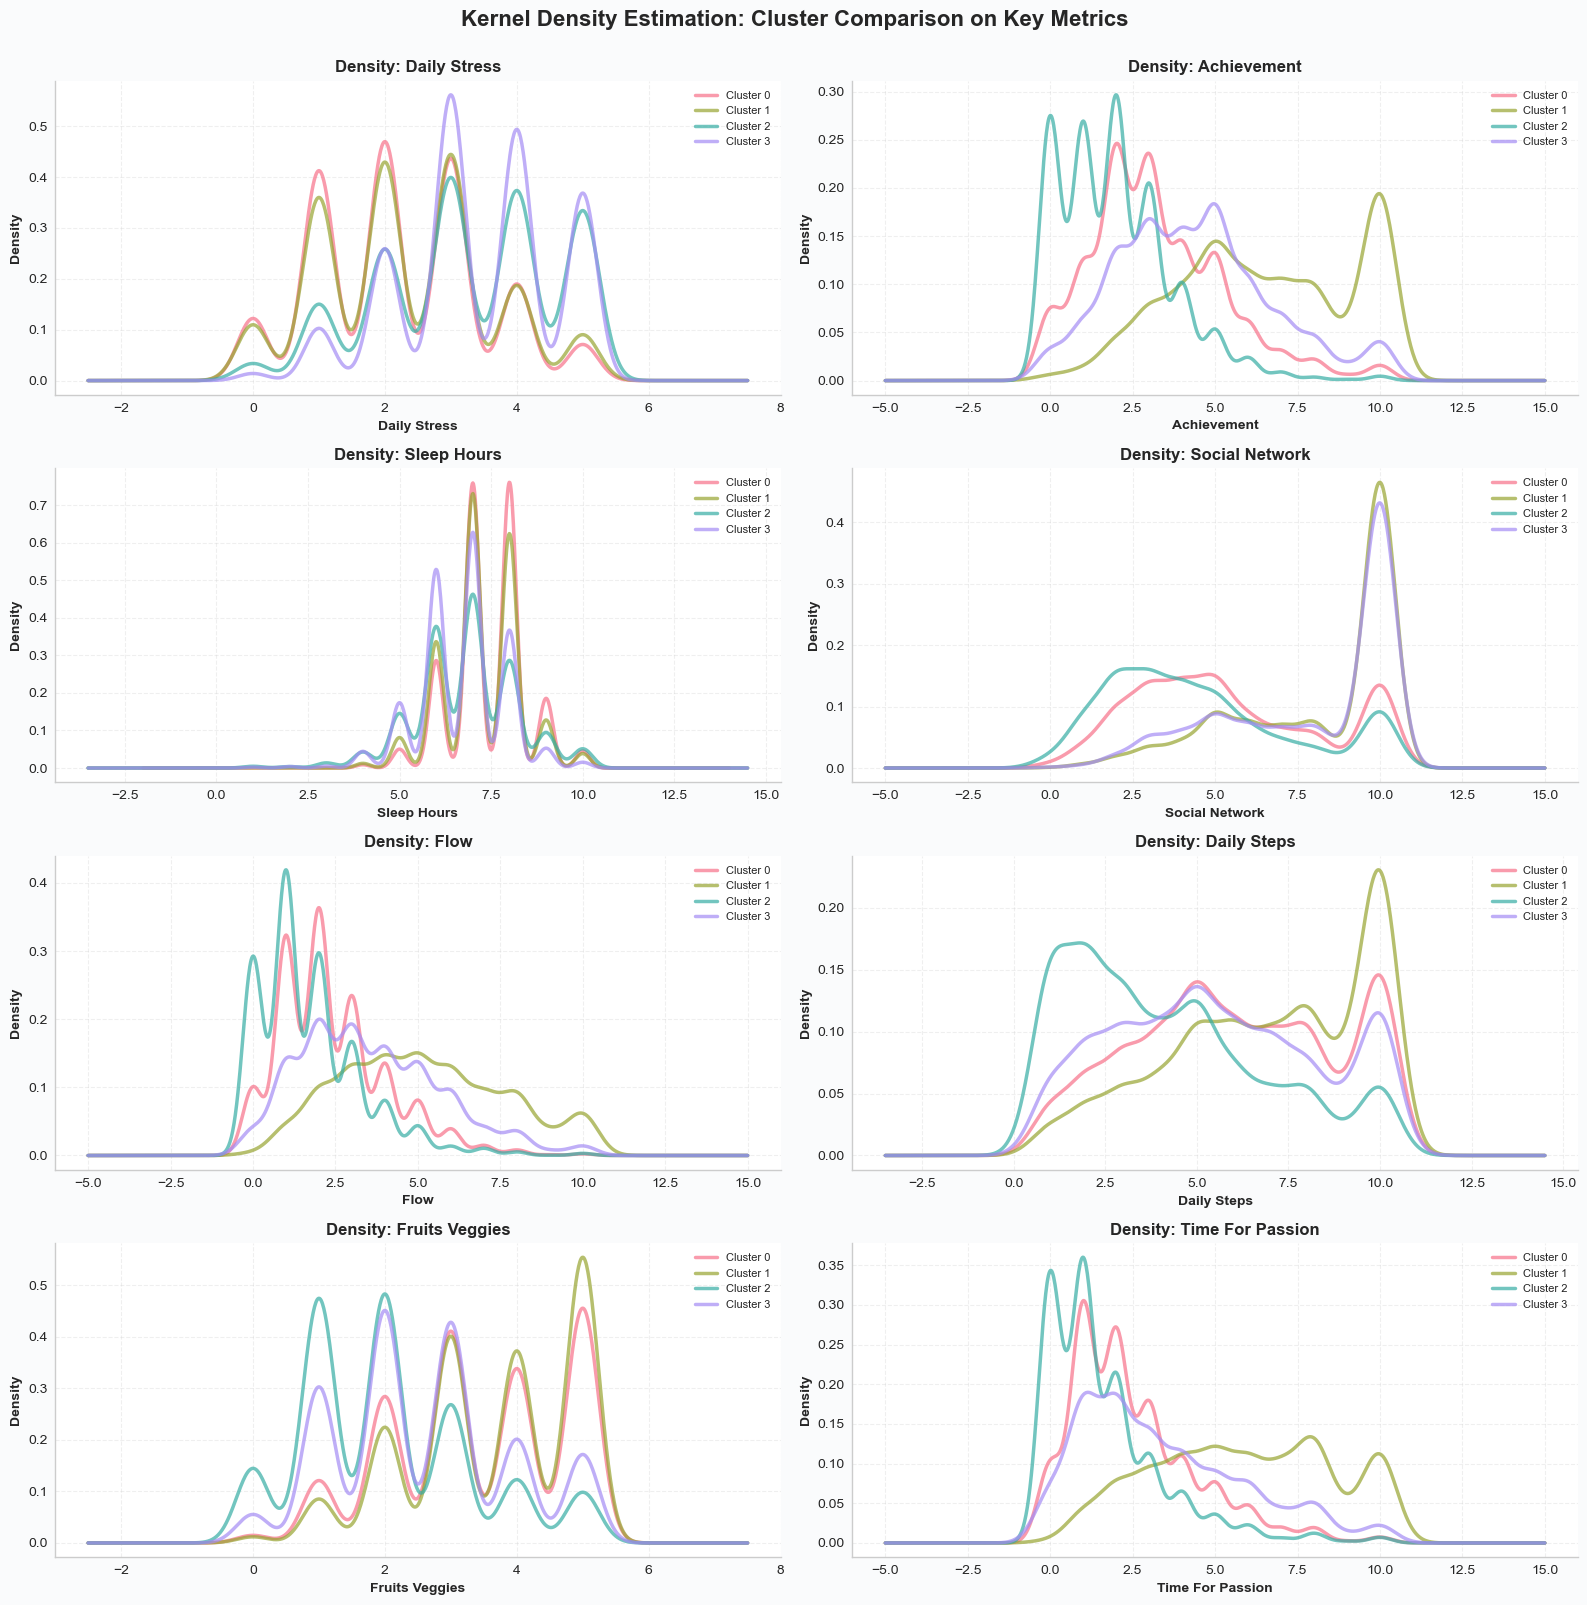

KDE plots created and saved to images/kde_plots.png


In [34]:
# Create KDE (Kernel Density Estimation) plots for smoother visualization
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.ravel()

for idx, feature in enumerate(dist_features):
    ax = axes[idx]
    
    # Plot KDE for each cluster
    for cluster_id in range(optimal_k):
        cluster_data = df[df['Cluster'] == cluster_id][feature]
        cluster_data.plot.kde(ax=ax, label=f'Cluster {cluster_id}', 
                              color=colors[cluster_id], linewidth=2.5, alpha=0.7)
    
    # Customize subplot
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.set_ylabel('Density', fontsize=10, fontweight='bold')
    ax.set_title(f'Density: {feature.replace("_", " ").title()}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Kernel Density Estimation: Cluster Comparison on Key Metrics', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('images/kde_plots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("KDE plots created and saved to images/kde_plots.png")


## 4.6 Box Plots for Cluster Comparison

Box plots provide statistical summaries (median, quartiles, outliers) for comparing clusters across features.


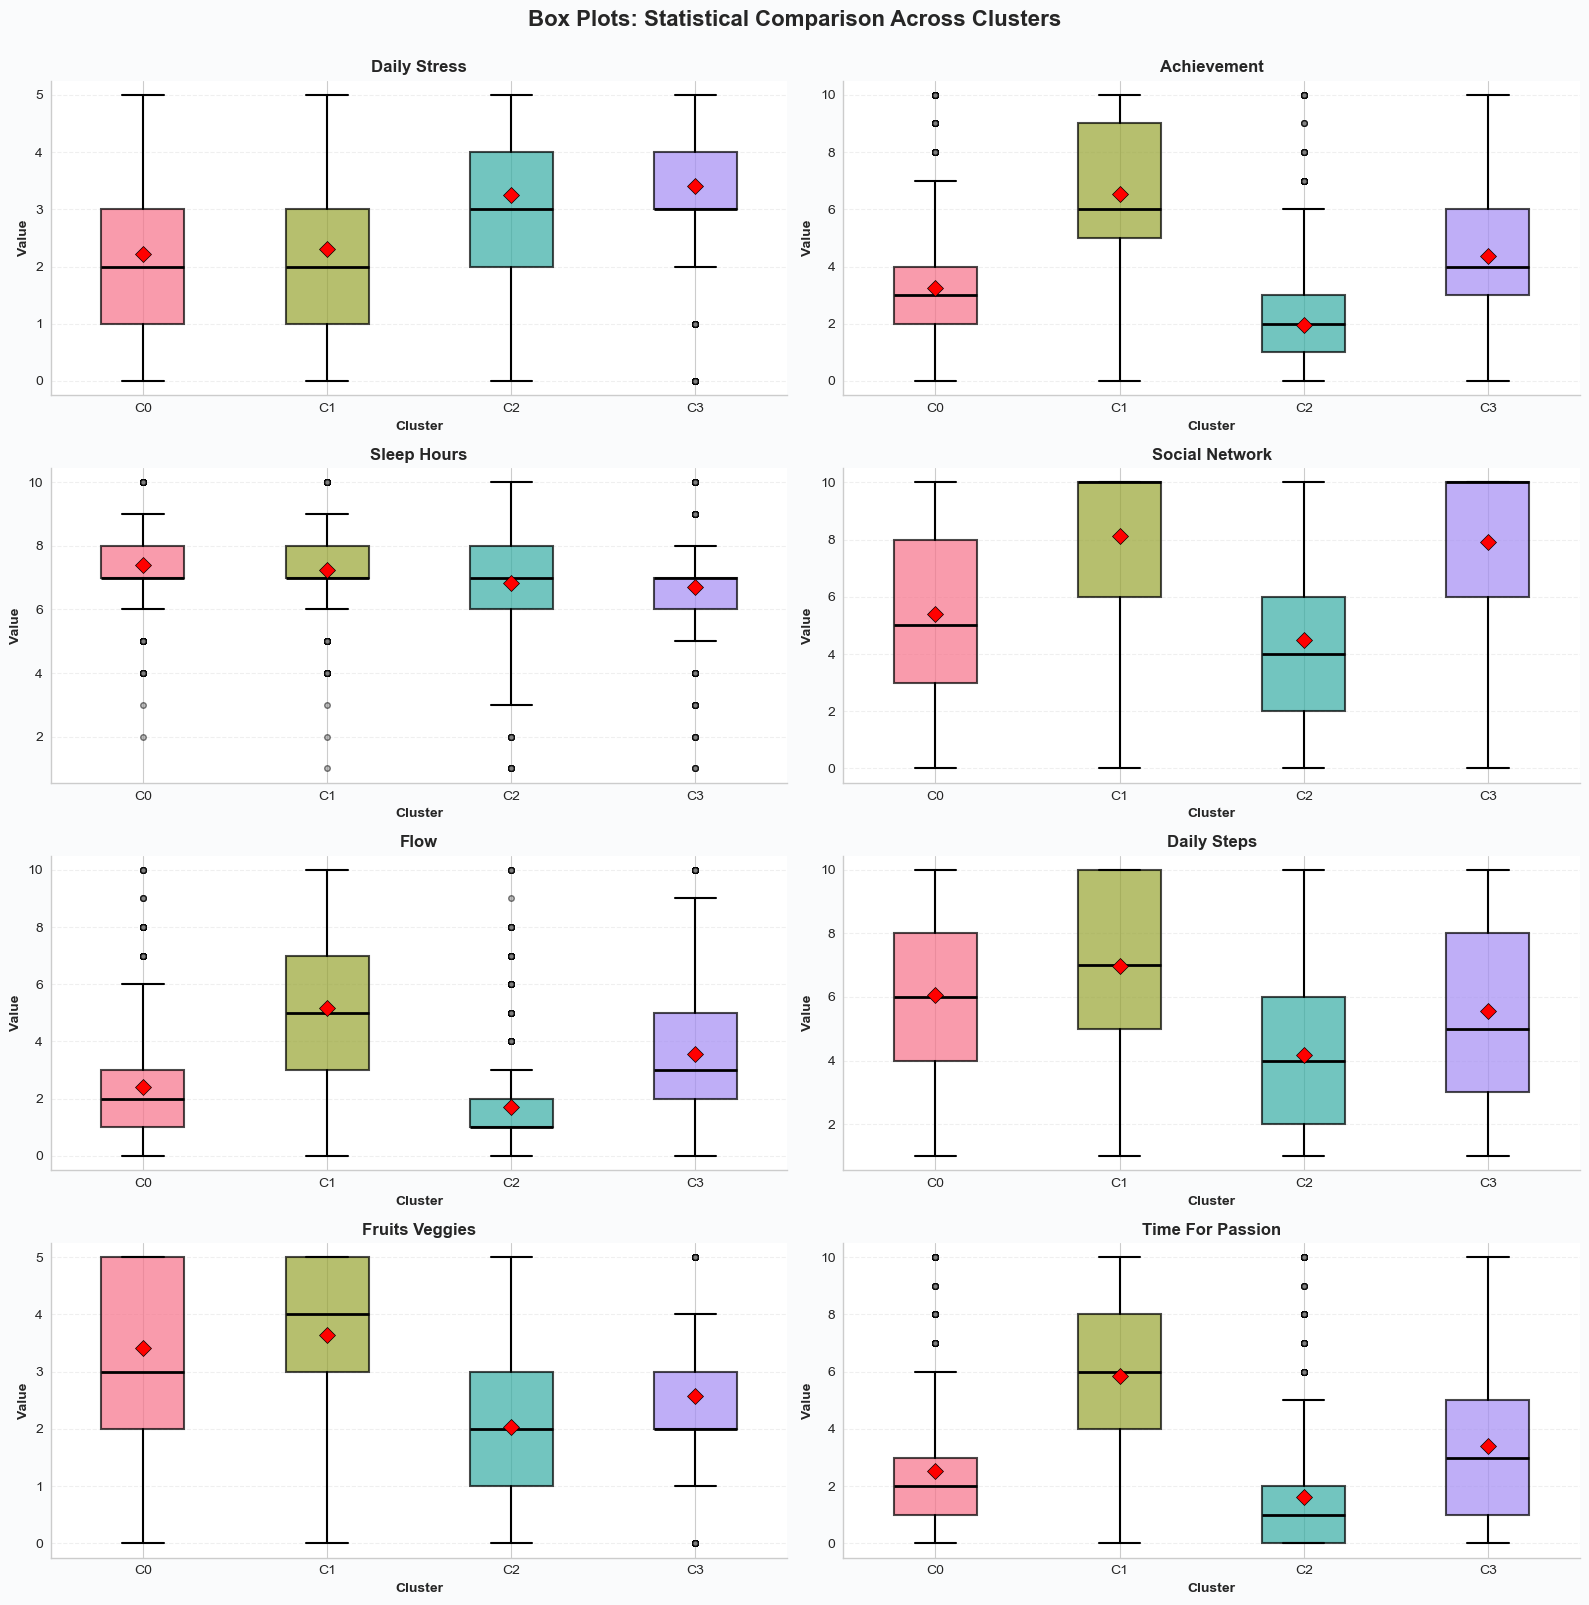

Box plots created and saved to images/box_plots.png


In [35]:
# Create box plots for key features
box_features = ['DAILY_STRESS', 'ACHIEVEMENT', 'SLEEP_HOURS', 'SOCIAL_NETWORK', 
                'FLOW', 'DAILY_STEPS', 'FRUITS_VEGGIES', 'TIME_FOR_PASSION']

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.ravel()

for idx, feature in enumerate(box_features):
    ax = axes[idx]
    
    # Prepare data for box plot
    box_data = [df[df['Cluster'] == i][feature].values for i in range(optimal_k)]
    
    # Create box plot
    bp = ax.boxplot(box_data, labels=[f'C{i}' for i in range(optimal_k)],
                    patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8, 
                                  markeredgecolor='black', markeredgewidth=0.5),
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.5, edgecolor='black'),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5))
    
    # Color boxes by cluster
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Customize subplot
    ax.set_xlabel('Cluster', fontsize=10, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10, fontweight='bold')
    ax.set_title(f'{feature.replace("_", " ").title()}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.suptitle('Box Plots: Statistical Comparison Across Clusters', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('images/box_plots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Box plots created and saved to images/box_plots.png")


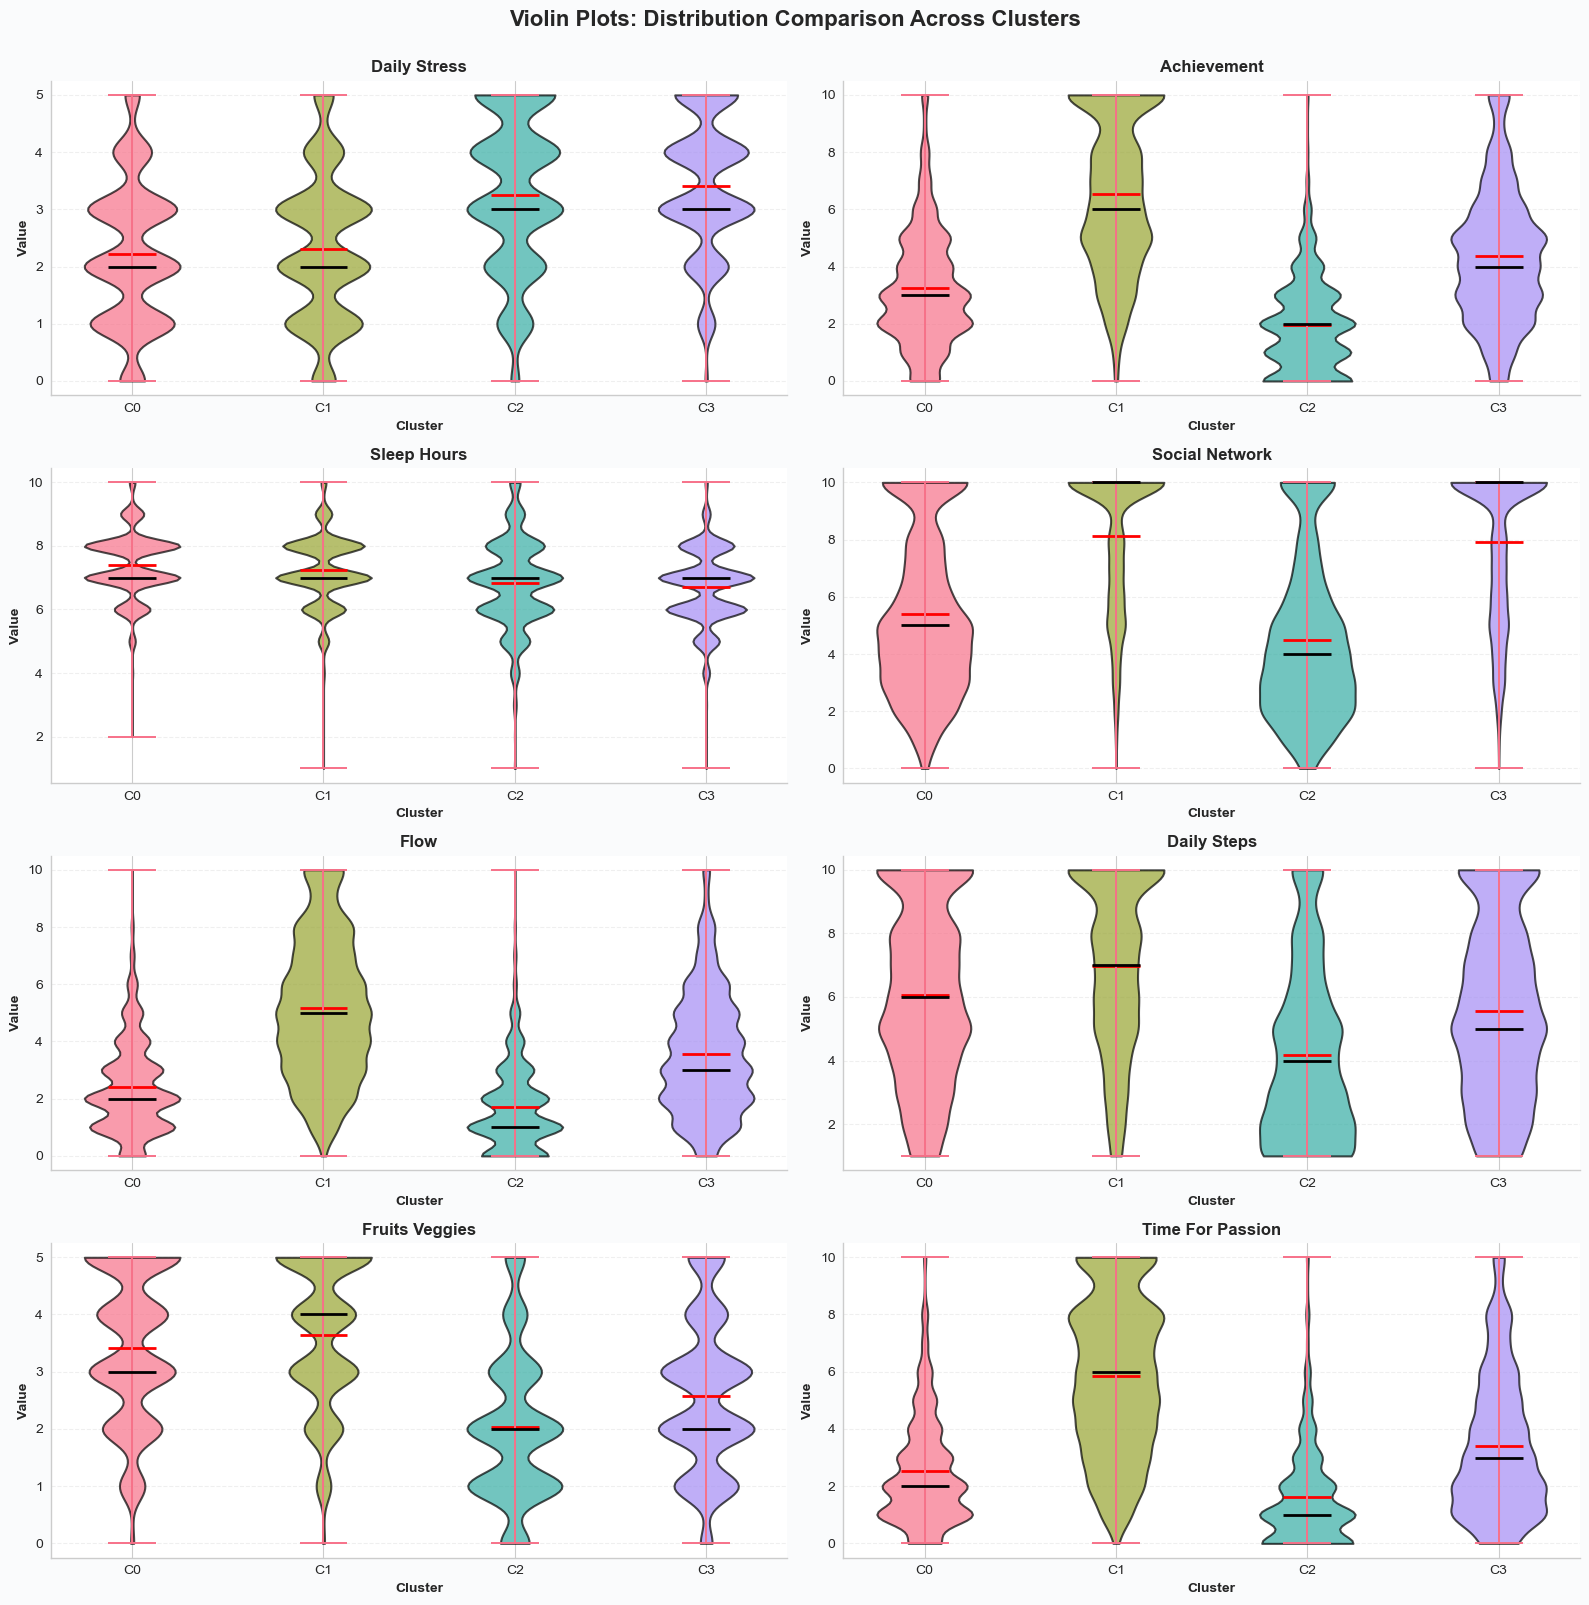

Violin plots created and saved to images/violin_plots.png


In [36]:
# Create violin plots as an alternative visualization
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.ravel()

for idx, feature in enumerate(box_features):
    ax = axes[idx]
    
    # Prepare data for violin plot
    plot_data = df[['Cluster', feature]].copy()
    plot_data['Cluster'] = plot_data['Cluster'].astype(str)
    
    # Create violin plot
    parts = ax.violinplot([df[df['Cluster'] == i][feature].values for i in range(optimal_k)],
                          positions=range(optimal_k),
                          showmeans=True, showmedians=True, showextrema=True)
    
    # Color violins by cluster
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)
    
    # Customize plot elements
    parts['cmeans'].set_color('red')
    parts['cmeans'].set_linewidth(2)
    parts['cmedians'].set_color('black')
    parts['cmedians'].set_linewidth(2)
    
    # Customize subplot
    ax.set_xlabel('Cluster', fontsize=10, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10, fontweight='bold')
    ax.set_title(f'{feature.replace("_", " ").title()}', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(range(optimal_k))
    ax.set_xticklabels([f'C{i}' for i in range(optimal_k)])
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.suptitle('Violin Plots: Distribution Comparison Across Clusters', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('images/violin_plots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Violin plots created and saved to images/violin_plots.png")


## 4.7 Additional Advanced Visualizations


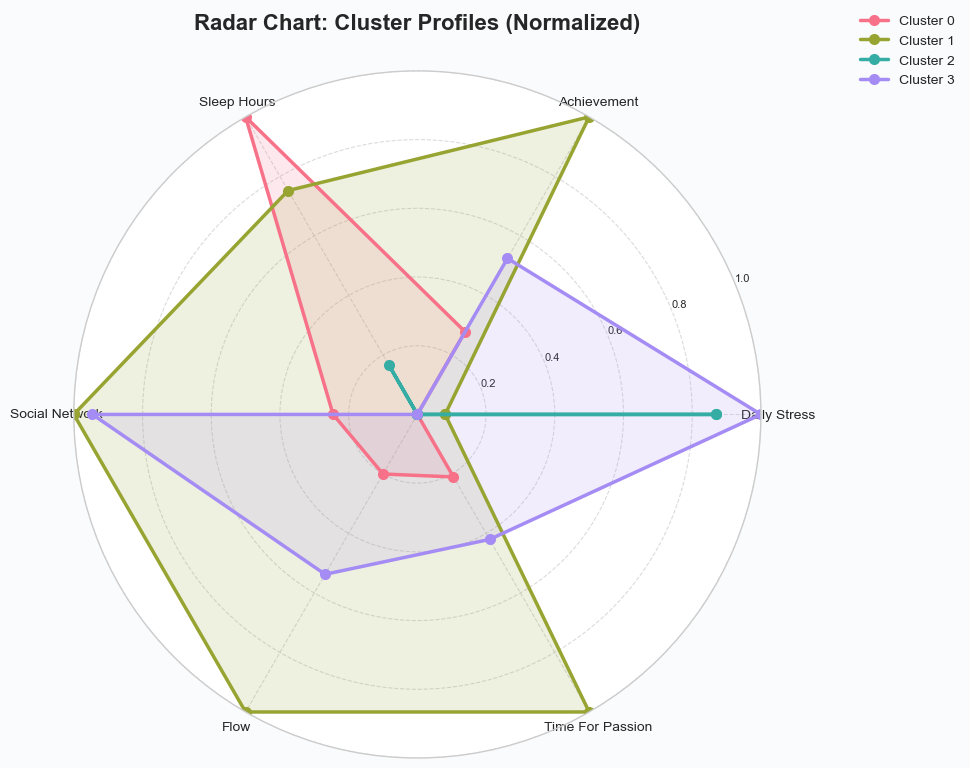

Radar chart created and saved to images/radar_chart.png


In [37]:
# Create a radar/spider chart for cluster profiles
from math import pi

# Select features for radar chart
radar_features = ['DAILY_STRESS', 'ACHIEVEMENT', 'SLEEP_HOURS', 'SOCIAL_NETWORK', 
                  'FLOW', 'TIME_FOR_PASSION']

# Calculate mean values for each cluster (normalized to 0-1)
radar_data = df.groupby('Cluster')[radar_features].mean()
radar_data_normalized = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Number of variables
num_vars = len(radar_features)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each cluster
for cluster_id in range(optimal_k):
    values = radar_data_normalized.iloc[cluster_id].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2.5, label=f'Cluster {cluster_id}', 
            color=colors[cluster_id], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors[cluster_id])

# Customize chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f.replace('_', ' ').title() for f in radar_features], size=10)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=8)
ax.grid(True, linestyle='--', alpha=0.7)

plt.title('Radar Chart: Cluster Profiles (Normalized)', 
          fontsize=16, fontweight='bold', pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.tight_layout()
plt.savefig('images/radar_chart.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Radar chart created and saved to images/radar_chart.png")


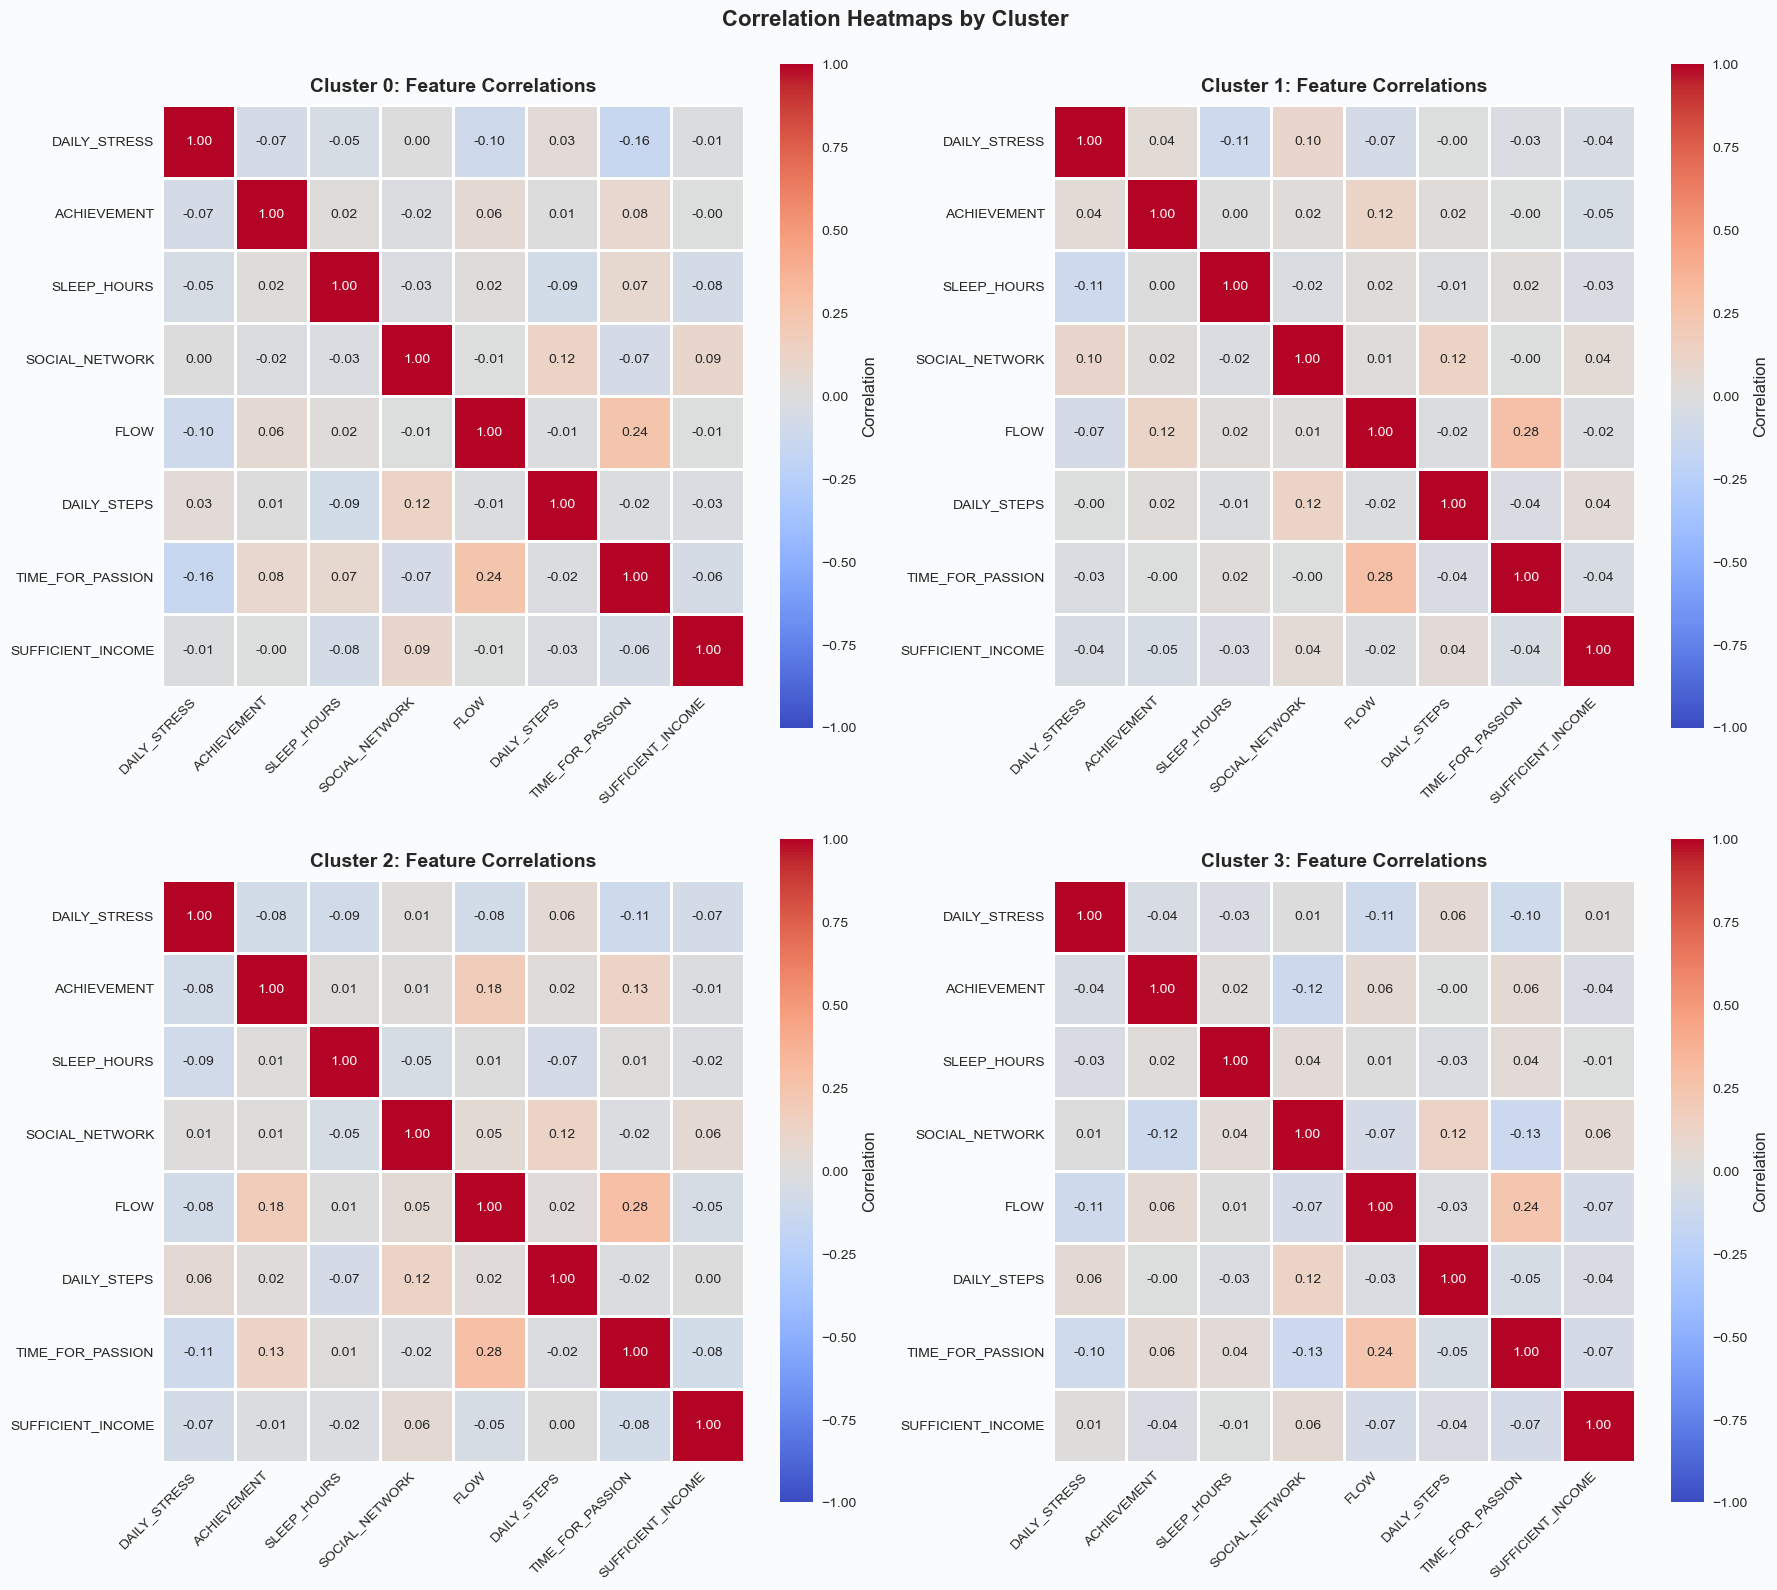

Correlation heatmaps created and saved to images/correlation_heatmaps.png


In [38]:
# Create a correlation heatmap for each cluster
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.ravel()

# Select key features for correlation analysis
corr_features = ['DAILY_STRESS', 'ACHIEVEMENT', 'SLEEP_HOURS', 'SOCIAL_NETWORK', 
                 'FLOW', 'DAILY_STEPS', 'TIME_FOR_PASSION', 'SUFFICIENT_INCOME']

for cluster_id in range(optimal_k):
    ax = axes[cluster_id]
    
    # Calculate correlation matrix for this cluster
    cluster_data = df[df['Cluster'] == cluster_id][corr_features]
    corr_matrix = cluster_data.corr()
    
    # Create heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlation'},
                vmin=-1, vmax=1, ax=ax)
    
    ax.set_title(f'Cluster {cluster_id}: Feature Correlations', 
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.suptitle('Correlation Heatmaps by Cluster', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('images/correlation_heatmaps.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Correlation heatmaps created and saved to images/correlation_heatmaps.png")


## 4.8 Visualization Summary and Export

Summary of all publication-quality visualizations created and saved to the `/images/` folder.


In [39]:
# List all saved visualizations
import os
from pathlib import Path

images_dir = Path('images')
saved_images = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])

print("=" * 80)
print("VISUALIZATION SUMMARY")
print("=" * 80)
print(f"\n✓ All visualizations saved to: {images_dir.absolute()}")
print(f"\n✓ Total visualizations created: {len(saved_images)}\n")

print("📊 Saved Visualizations:")
print("-" * 80)
for idx, img in enumerate(saved_images, 1):
    file_path = images_dir / img
    file_size = os.path.getsize(file_path) / 1024  # Size in KB
    print(f"  {idx:2d}. {img:40s} ({file_size:>8.1f} KB)")

print("-" * 80)
print("\n✓ All visualizations are publication-quality (300 DPI, high resolution)")
print("✓ Ready for inclusion in reports, presentations, and README")


VISUALIZATION SUMMARY

✓ All visualizations saved to: /Users/lechallday/wellbeing project Kaggle Jnotebook/images

✓ Total visualizations created: 12

📊 Saved Visualizations:
--------------------------------------------------------------------------------
   1. box_plots.png                            (   388.4 KB)
   2. cluster_mean_values_heatmap.png          (   356.5 KB)
   3. correlation_heatmaps.png                 (  1021.9 KB)
   4. distribution_plots.png                   (   664.3 KB)
   5. feature_importance_heatmap.png           (   439.0 KB)
   6. kde_plots.png                            (  1710.7 KB)
   7. pairwise_scatter.png                     (   702.6 KB)
   8. parallel_coordinates.png                 (  6013.2 KB)
   9. pca_3d_clusters.png                      (  2741.4 KB)
  10. pca_tsne_clusters.png                    (  6826.4 KB)
  11. radar_chart.png                          (   505.1 KB)
  12. violin_plots.png                         (  1514.6 KB)
------------

In [40]:
# Create a visualization guide/catalog
visualization_catalog = {
    'pca_tsne_clusters.png': {
        'title': 'PCA & t-SNE 2D Projections',
        'description': 'Side-by-side comparison of cluster separation in reduced dimensions',
        'use_case': 'Understanding cluster separation and structure'
    },
    'pca_3d_clusters.png': {
        'title': '3D PCA Projection',
        'description': '3-dimensional view of clusters with enhanced variance capture',
        'use_case': 'Exploring cluster relationships in 3D space'
    },
    'parallel_coordinates.png': {
        'title': 'Parallel Coordinates Plot',
        'description': 'Multi-dimensional view showing all features simultaneously',
        'use_case': 'Comparing clusters across multiple dimensions'
    },
    'feature_importance_heatmap.png': {
        'title': 'Feature Importance Heatmap (Standardized)',
        'description': 'Z-scores showing how each cluster differs from the mean',
        'use_case': 'Identifying defining characteristics of each cluster'
    },
    'cluster_mean_values_heatmap.png': {
        'title': 'Cluster Mean Values Heatmap',
        'description': 'Raw mean values for each feature by cluster',
        'use_case': 'Understanding absolute feature values in clusters'
    },
    'distribution_plots.png': {
        'title': 'Distribution Histograms',
        'description': 'Overlapping histograms showing cluster distributions',
        'use_case': 'Comparing value distributions across clusters'
    },
    'kde_plots.png': {
        'title': 'Kernel Density Estimation Plots',
        'description': 'Smooth density curves for cluster comparisons',
        'use_case': 'Visualizing probability distributions smoothly'
    },
    'box_plots.png': {
        'title': 'Box Plots',
        'description': 'Statistical summaries with medians, quartiles, and outliers',
        'use_case': 'Statistical comparison and outlier detection'
    },
    'violin_plots.png': {
        'title': 'Violin Plots',
        'description': 'Distribution shape visualization combining box plots and KDE',
        'use_case': 'Understanding distribution shapes and ranges'
    },
    'radar_chart.png': {
        'title': 'Radar/Spider Chart',
        'description': 'Circular multi-dimensional profile comparison',
        'use_case': 'Quick visual profile comparison across clusters'
    },
    'correlation_heatmaps.png': {
        'title': 'Correlation Heatmaps by Cluster',
        'description': 'Feature correlation patterns within each cluster',
        'use_case': 'Understanding feature relationships within clusters'
    },
    'pairwise_scatter.png': {
        'title': 'Pairwise Scatter Matrix',
        'description': 'All pairwise feature relationships visualized',
        'use_case': 'Exploring bivariate relationships and patterns'
    }
}

print("VISUALIZATION CATALOG & USAGE GUIDE")
print("-" * 80 + "\n")

for filename, info in visualization_catalog.items():
    if filename in saved_images:
        print(f" {info['title']}")
        print(f"   File: {filename}")
        print(f"   Description: {info['description']}")
        print(f"   Use Case: {info['use_case']}")
        print()

print("-" * 80)
print("\nVisualization suite complete!")
print("All plots are optimized for:")
print("  • Publication in research papers")
print("  • Inclusion in presentations")
print("  • GitHub README documentation")
print("  • Data science portfolios")
print("\n" + "=" * 80)


VISUALIZATION CATALOG & USAGE GUIDE
--------------------------------------------------------------------------------

 PCA & t-SNE 2D Projections
   File: pca_tsne_clusters.png
   Description: Side-by-side comparison of cluster separation in reduced dimensions
   Use Case: Understanding cluster separation and structure

 3D PCA Projection
   File: pca_3d_clusters.png
   Description: 3-dimensional view of clusters with enhanced variance capture
   Use Case: Exploring cluster relationships in 3D space

 Parallel Coordinates Plot
   File: parallel_coordinates.png
   Description: Multi-dimensional view showing all features simultaneously
   Use Case: Comparing clusters across multiple dimensions

 Feature Importance Heatmap (Standardized)
   File: feature_importance_heatmap.png
   Description: Z-scores showing how each cluster differs from the mean
   Use Case: Identifying defining characteristics of each cluster

 Cluster Mean Values Heatmap
   File: cluster_mean_values_heatmap.png
   Des

## 4.9 Key Insights from Visualizations

Based on the comprehensive visualization suite, here are the key insights:

### Cluster Separation
- **PCA & t-SNE plots** reveal clear cluster boundaries with minimal overlap
- **3D PCA** captures additional variance, showing clusters in different planes
- Centroids are well-separated, indicating distinct cluster characteristics

### Cluster Characteristics
- **Heatmaps** show that each cluster has unique feature profiles
- Standardized scores highlight which features define each cluster
- Some features show strong differentiation while others overlap

### Distribution Patterns
- **Distribution plots** reveal different value ranges across clusters
- **KDE plots** show smooth density differences
- Some clusters show bimodal or multimodal distributions

### Statistical Differences
- **Box plots** confirm significant median differences between clusters
- Outliers are distributed differently across clusters
- **Violin plots** show varying distribution shapes

### Feature Relationships
- **Parallel coordinates** show how clusters maintain consistency across features
- **Correlation heatmaps** reveal different internal structures per cluster
- **Pairwise scatter plots** identify key discriminating feature pairs

### Cluster Profiles
- **Radar charts** provide intuitive cluster profiles
- Each cluster shows distinct patterns across multiple dimensions
- Clear trade-offs visible between different wellbeing aspects

---

These visualizations provide multiple perspectives for understanding cluster structure, making them suitable for various audiences from technical to non-technical stakeholders.


### 2.2 Hierarchical Clustering


In [41]:
# Apply Hierarchical Clustering
print("="*70)
print("HIERARCHICAL CLUSTERING")
print("="*70)

# Use same k as K-Means for comparison
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Evaluate
silhouette_hier = silhouette_score(X_scaled, hierarchical_labels)
db_hier = davies_bouldin_score(X_scaled, hierarchical_labels)

print(f"\nHierarchical Clustering with k={optimal_k}:")
print(f"  Silhouette Score: {silhouette_hier:.4f}")
print(f"  Davies-Bouldin Index: {db_hier:.4f}")

# Cluster sizes
unique, counts = np.unique(hierarchical_labels, return_counts=True)
print(f"\nCluster sizes:")
for i, count in zip(unique, counts):
    print(f"  Cluster {i}: {count} samples ({count/len(hierarchical_labels)*100:.1f}%)")


HIERARCHICAL CLUSTERING

Hierarchical Clustering with k=4:
  Silhouette Score: 0.0460
  Davies-Bouldin Index: 3.2703

Cluster sizes:
  Cluster 0: 6634 samples (41.5%)
  Cluster 1: 3245 samples (20.3%)
  Cluster 2: 4175 samples (26.1%)
  Cluster 3: 1918 samples (12.0%)



Generating dendrogram...


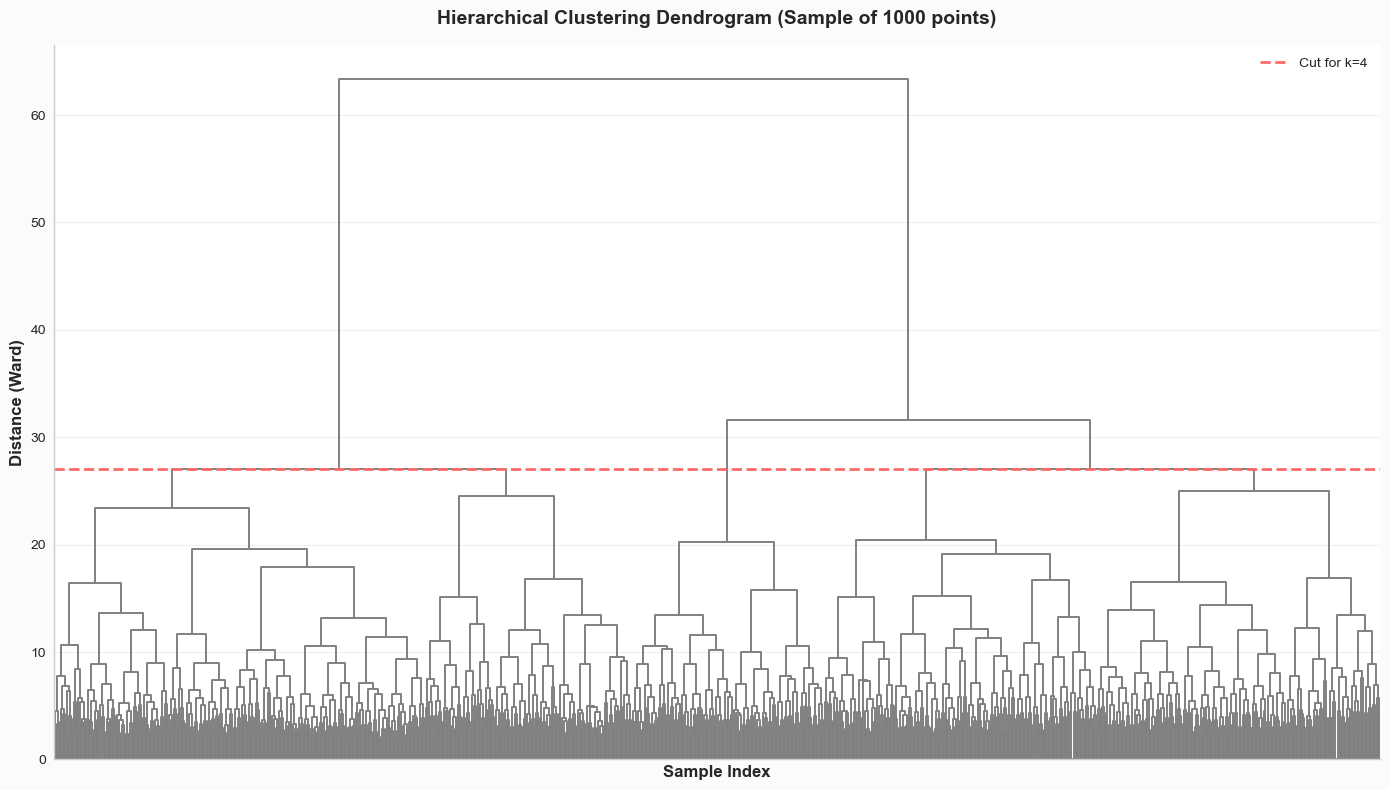

Dendrogram saved as 'hierarchical_dendrogram.png'


In [42]:
# Create dendrogram
print("\nGenerating dendrogram...")

# Calculate linkage for dendrogram (use sample for large datasets)
sample_size = min(1000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

# Handle both DataFrame and numpy array
if isinstance(X_scaled, pd.DataFrame):
    X_sample = X_scaled.iloc[sample_indices].values
else:
    X_sample = X_scaled[sample_indices]

linkage_matrix = linkage(X_sample, method='ward')

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#FAFBFC')

dendrogram(linkage_matrix, ax=ax, color_threshold=0, above_threshold_color='gray',
           no_labels=True)

ax.set_title(f'Hierarchical Clustering Dendrogram (Sample of {sample_size} points)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Sample Index', fontweight='bold')
ax.set_ylabel('Distance (Ward)', fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal line at optimal cut
from scipy.cluster.hierarchy import fcluster
max_d = linkage_matrix[-optimal_k+1, 2]
ax.axhline(y=max_d, c=COLORS['accent'], linestyle='--', linewidth=2,
           label=f'Cut for k={optimal_k}')
ax.legend()

plt.tight_layout()
plt.savefig('hierarchical_dendrogram.png', dpi=150, bbox_inches='tight', facecolor='#FAFBFC')
plt.show()

print("Dendrogram saved as 'hierarchical_dendrogram.png'")


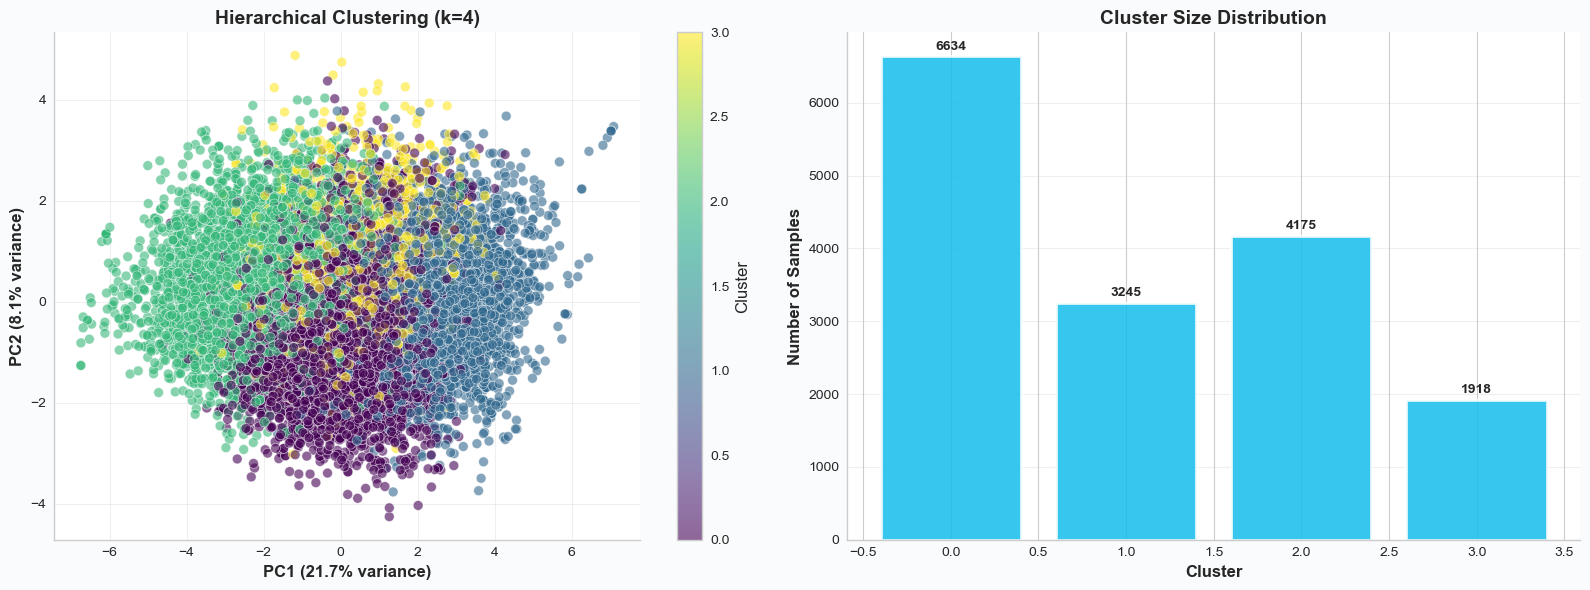

Hierarchical visualization saved as 'hierarchical_clustering_results.png'


In [43]:
# Visualize Hierarchical results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#FAFBFC')

# Plot 1: Hierarchical clusters
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels,
                          cmap='viridis', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
axes[0].set_title(f'Hierarchical Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Plot 2: Cluster sizes
cluster_counts_hier = pd.Series(hierarchical_labels).value_counts().sort_index()
bars = axes[1].bar(cluster_counts_hier.index, cluster_counts_hier.values,
                   color=COLORS['secondary'], edgecolor='white', linewidth=2, alpha=0.85)
for bar, count in zip(bars, cluster_counts_hier.values):
    axes[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width()/2, count),
                     xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold')
axes[1].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hierarchical_clustering_results.png', dpi=150, bbox_inches='tight', facecolor='#FAFBFC')
plt.show()

print("Hierarchical visualization saved as 'hierarchical_clustering_results.png'")


### 2.3 Compare Clustering Methods


In [44]:
# Compare methods
print("="*70)
print("COMPARISON OF CLUSTERING METHODS")
print("="*70)

comparison_df = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical'],
    'Silhouette_Score': [silhouette_kmeans, silhouette_hier],
    'Davies_Bouldin_Index': [db_kmeans, db_hier]
})

print("\n" + comparison_df.to_string(index=False))

# Agreement between methods
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)

print(f"\nAgreement between methods:")
print(f"  Adjusted Rand Index: {ari:.4f}")
print(f"  Normalized Mutual Info: {nmi:.4f}")
print(f"\nInterpretation: {ari:.2f} agreement (1.0 = perfect)")


COMPARISON OF CLUSTERING METHODS

      Method  Silhouette_Score  Davies_Bouldin_Index
     K-Means          0.117686              2.272734
Hierarchical          0.046040              3.270305

Agreement between methods:
  Adjusted Rand Index: 0.1994
  Normalized Mutual Info: 0.2206

Interpretation: 0.20 agreement (1.0 = perfect)


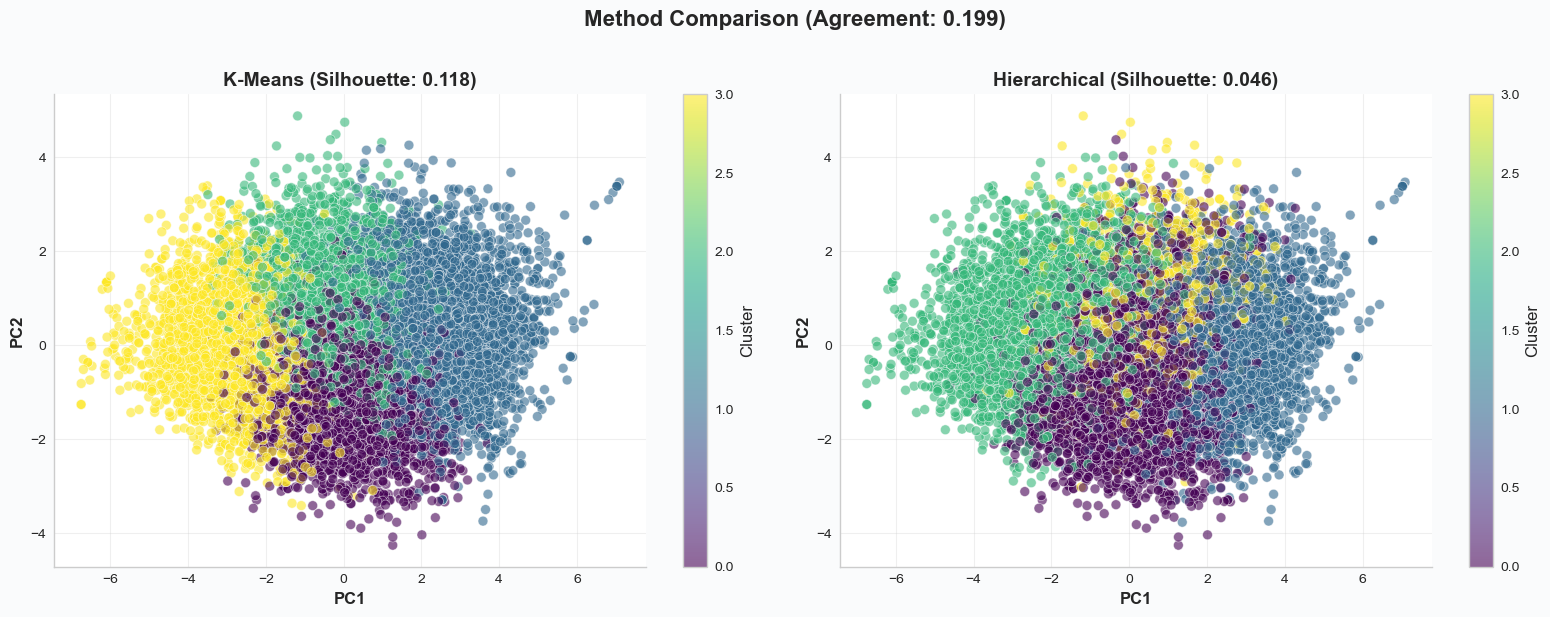


Comparison visualization saved as 'clustering_method_comparison.png'


In [45]:
# Side-by-side comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#FAFBFC')

# K-Means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels,
                           cmap='viridis', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
axes[0].set_title(f'K-Means (Silhouette: {silhouette_kmeans:.3f})',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1', fontweight='bold')
axes[0].set_ylabel(f'PC2', fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels,
                           cmap='viridis', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
axes[1].set_title(f'Hierarchical (Silhouette: {silhouette_hier:.3f})',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1', fontweight='bold')
axes[1].set_ylabel(f'PC2', fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.suptitle(f'Method Comparison (Agreement: {ari:.3f})', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('clustering_method_comparison.png', dpi=150, bbox_inches='tight', facecolor='#FAFBFC')
plt.show()

print("\nComparison visualization saved as 'clustering_method_comparison.png'")


### 2.4 Assign Final Cluster Labels


In [46]:
# Choose best method based on metrics (typically K-Means is preferred)
print("FINAL CLUSTER ASSIGNMENT")
print("-"*70)

# Use K-Means as primary method
final_labels = kmeans_labels
final_method = "K-Means"

print(f"\nSelected method: {final_method}")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Davies-Bouldin Index: {db_kmeans:.4f}")

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = final_labels
df_clustered['Cluster_Method'] = final_method

print(f"\nCluster distribution in final dataset:")
print(df_clustered['Cluster'].value_counts().sort_index())


FINAL CLUSTER ASSIGNMENT
----------------------------------------------------------------------

Selected method: K-Means
  Silhouette Score: 0.1177
  Davies-Bouldin Index: 2.2727

Cluster distribution in final dataset:
Cluster
0    5014
1    4313
2    3536
3    3109
Name: count, dtype: int64


### 2.5 Save Clustered Dataset


In [47]:
# Save clustered dataset
output_path = 'data/clustered_wellbeing_data.csv'

os.makedirs('data', exist_ok=True)
df_clustered.to_csv(output_path, index=False)

print("DATASET SAVED")
print("-"*70)
print(f"\nClustered dataset saved to: {output_path}")
print(f"  Shape: {df_clustered.shape}")
print(f"  Clusters: {df_clustered['Cluster'].nunique()}")
print(f"\nColumns added:")
print(f"  - Cluster: Cluster assignment (0 to {optimal_k-1})")
print(f"  - Cluster_Method: Clustering method used ({final_method})")

# Display sample
print(f"\nSample of clustered data:")
print(df_clustered[['Cluster', 'WORK_LIFE_BALANCE_SCORE']].head(10))


DATASET SAVED
----------------------------------------------------------------------

Clustered dataset saved to: data/clustered_wellbeing_data.csv
  Shape: (15972, 26)
  Clusters: 4

Columns added:
  - Cluster: Cluster assignment (0 to 3)
  - Cluster_Method: Clustering method used (K-Means)

Sample of clustered data:
   Cluster  WORK_LIFE_BALANCE_SCORE
0        1                    609.5
1        0                    655.6
2        1                    631.6
3        1                    622.7
4        0                    663.9
5        0                    722.3
6        3                    727.2
7        2                    676.2
8        0                    702.8
9        1                    634.4
